<a href="https://colab.research.google.com/github/Zhang-Cheng-76200/Conformal-prediction/blob/main/Multistep_CapsNet_LSTM_SP500.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multistage prediction with CAPSNET-LSTM (SP500)

In [2]:
import keras.backend as K
import tensorflow as tf

import keras
from keras import backend as K
from keras import initializers, layers, models, optimizers, callbacks, utils
from keras.models import load_model
from keras.models import model_from_json

from keras.initializers import glorot_uniform

from keras.initializers import *
from keras.layers import *
from keras.models import *
from keras.optimizers import *
from keras.callbacks import EarlyStopping
from keras.utils import *

from keras import losses
from keras.utils.io_utils import ask_to_proceed_with_overwrite
from tensorflow.python.platform import tf_logging as logging

import os
import copy
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass




In [3]:
import random

In [4]:
# Set seed
from numpy.random import seed
seed(1)
tf.random.set_seed(1)

In [5]:
# If code is running on TPU
resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='')
tf.config.experimental_connect_to_cluster(resolver)
# This is the TPU initialization code that has to be at the beginning.
tf.tpu.experimental.initialize_tpu_system(resolver)
print("All devices: ", tf.config.list_logical_devices('TPU'))

All devices:  [LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:0', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:1', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:2', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:3', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:4', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:5', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:6', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:7', device_type='TPU')]


In [6]:
strategy = tf.distribute.TPUStrategy(resolver)

In [7]:
print(tf.__version__)

2.11.0


# Parsing the raw data

A couple of things to note:

- There is no need to save the data points as numpy arrays, regular lists is fine.
- The `time` list should contain every timestep (starting at zero), which is just a sequence of ordered numbers with the same length as the `series` list.
- The values of the `series` should be of `float` type. You can use Python's built-in `float` function to ensure this.

Begin by looking at the structure of the xlsx file that contains the data:

In [8]:
from google.colab import drive
drive.mount ('gdrive')

Mounted at gdrive


In [9]:
SP500_raw = pd.read_excel('/content/gdrive/MyDrive/Multistage/SP500.xlsx')
SP500_raw

,Date,Open,High,Low,Close*,Adj Close**,Volume
0,2010-04-01 00:00:00,1116.56,1133.87,1116.56,1132.99,1132.99,3991400000
1,2010-05-01 00:00:00,1132.66,1136.63,1129.66,1136.52,1136.52,2491020000
2,2010-06-01 00:00:00,1135.71,1139.19,1133.95,1137.14,1137.14,4972660000
3,2010-07-01 00:00:00,1136.27,1142.46,1131.32,1141.69,1141.69,5270680000
4,2010-08-01 00:00:00,1140.52,1145.39,1136.22,1144.98,1144.98,4389590000
...,...,...,...,...,...,...,...
2511,12/24/19,3225.45,3226.43,3220.51,3223.38,3223.38,1296530000
2512,12/26/19,3227.20,3240.08,3227.20,3239.91,3239.91,2164540000
2513,12/27/19,3247.23,3247.93,3234.37,3240.02,3240.02,2429150000
2514,12/30/19,3240.09,3240.92,3216.57,3221.29,3221.29,3021720000


In [10]:
series = SP500_raw.iloc[:,4] # close price

In [11]:
time = []
for i in range(0, len(series)):
  time.append(i)

A helper function to plot the time series:

In [12]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

The next cell will use functions to compute the `time` and `series` and will save these as numpy arrays within the `G` dataclass. This cell will also plot the time series:

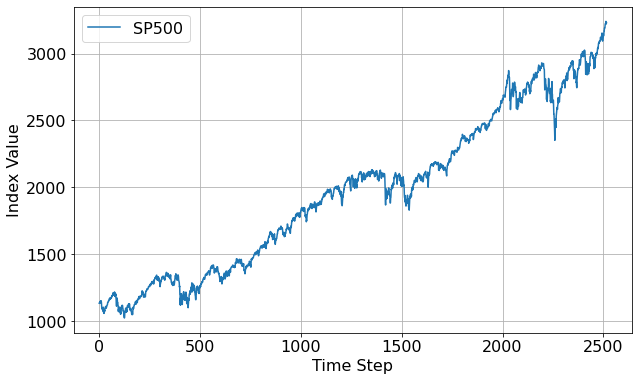

In [13]:
# Save all "global" variables within the G class (G stands for global)
@dataclass
class G:
    TIME = np.array(time)
    SERIES = np.array(series)
    SPLIT_TIME = 150          # data splitting, the last 150 samples are test set.
    WINDOW_SIZE = 50                                # sequence length
    BATCH_SIZE = 32                                  # batch size

plt.rcParams['font.size'] = '16'
plt.figure(figsize=(10, 6))
plot_series(G.TIME, G.SERIES)
plt.ylabel("Index Value")
plt.xlabel("Time Step")
legend_drawn_flag = True
plt.legend(["SP500"], loc=0, frameon=legend_drawn_flag)
plt.savefig("/content/gdrive/MyDrive/Multistage/figures/SP500_original.svg")
plt.show()

In [14]:
series_y = series[G.WINDOW_SIZE:]

# Processing the data

The `train_test_split` and `windowed_dataset` functions:

In [15]:
def train_test_split(time, series, time_step=G.SPLIT_TIME):

    time_train = time[:-G.SPLIT_TIME]
    series_train = series[:-G.SPLIT_TIME]
    time_test = time[-G.SPLIT_TIME:]
    series_test = series[-G.SPLIT_TIME:]

    return time_train, series_train, time_test, series_test



In [16]:
time_train, series_train, time_test, series_test = train_test_split(G.TIME, series)

In [17]:
# Split the dataset
time_train, series_train, time_test, series_test = train_test_split(G.TIME, G.SERIES)


In [18]:
def min_max_normalization(series):
  series = (series - min(series[:-G.SPLIT_TIME]))/(max(series[:-G.SPLIT_TIME]) - min(series[:-G.SPLIT_TIME]))
  return series

In [121]:

series_norm = min_max_normalization(G.SERIES)



In [122]:
# Create train_set, val_set, and train_val_set. train_set and val_set are used for hyper=parameters tuning, and train_val_set is used for training.
def windowed_dataset_one_step(series, window_size=G.WINDOW_SIZE, batch_size=G.BATCH_SIZE):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.map(lambda w: (w[:-1], w[-1]))
    ds = ds.batch(batch_size).prefetch(1)
    return ds


In [123]:
def windowed_dataset_ten_step(series, window_size=G.WINDOW_SIZE, batch_size=G.BATCH_SIZE):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 10, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 10))
    ds = ds.map(lambda w: (w[:-10], w[-10:]))
    ds = ds.batch(batch_size).prefetch(1)
    return ds


In [22]:
train_set_ten_step = windowed_dataset_ten_step(series_norm[:-G.SPLIT_TIME], window_size=G.WINDOW_SIZE, batch_size=G.BATCH_SIZE)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [96]:
train_set_one_step = windowed_dataset_one_step(series_norm[:-G.SPLIT_TIME], window_size=G.WINDOW_SIZE, batch_size=G.BATCH_SIZE)

In [23]:
def compute_metrics(true_series, forecast):
    
    mse = tf.keras.metrics.mean_squared_error(true_series, forecast).numpy()   
    rmse = tf.math.sqrt(mse).numpy()
    mae = tf.keras.metrics.mean_absolute_error(true_series, forecast).numpy()
    mape = tf.keras.metrics.mean_absolute_percentage_error(true_series, forecast).numpy()
    return rmse, mae, mape

In [131]:
def model_forecast(model, series, window_size):
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size, shift=1, drop_remainder=True)
  ds = ds.flat_map(lambda w: w.batch(window_size))
  ds = ds.batch(32).prefetch(1)
  forecast = model.predict(ds)
  return forecast

In [25]:
def reverse_normalization(series, series_train):
  series = series * (max(series_train) - min(series_train)) + min(series_train)
  return series

In [26]:
# Prepare callback

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='mae', factor=0.95,patience=5)

In [27]:
input_shape = (G.WINDOW_SIZE, 1)

In [28]:
K.clear_session()

# Compiling the model


## Defining the model architecture (CapsNet-LSTM)


In [29]:
# Squash function

def squash(vectors, axis=-1):
    """
    The non-linear activation used in Capsule. It drives the length of a large vector to near 1 and small vector to 0
    :param vectors: some vectors to be squashed, N-dim tensor
    :param axis: the axis to squash
    :return: a Tensor with same shape as input vectors
    """
    s_squared_norm = K.sum(K.square(vectors), axis, keepdims=True) 
    scale = s_squared_norm / (1 + s_squared_norm) / K.sqrt(s_squared_norm + K.epsilon())
    return scale * vectors


In [30]:
# Dynamic routing (layer)
#    The capsule layer. It is similar to Dense layer. Dense layer has `in_num` inputs, each is a scalar, the output of the 
#    neuron from the former layer, and it has `out_num` output neurons. CapsuleLayer just expand the output of the neuron
#    from scalar to vector. So its input shape = [None, input_num_capsule, input_dim_capsule] and output shape = \
#    [None, num_capsule, dim_capsule]. For Dense Layer, input_dim_capsule = dim_capsule = 1.

#    :param dim_capsule: dimension of the output vectors of the capsules in this layer
#    :param routings: number of iterations for the routing algorithm 

#@tf.keras.utils.register_keras_serializable() should use this line next time when need to save the model with a custom layer.
class Routing(keras.layers.Layer):

    def __init__(self, dim_capsule = 32 , routings=3, kernel_initializer='glorot_uniform'):
        super(Routing, self).__init__()
        self.dim_capsule = dim_capsule
        self.routings = routings
        self.kernel_initializer = initializers.get(kernel_initializer)

    def build(self, input_shape):
        # build tansform matrix which can convert one primary cap to a vector with the same order as the digit cap.
        # assert len(input_shape) >= 3  # The input Tensor should have shape=[None, input_num_capsule, input_dim_capsule]
        self.input_num_capsule = input_shape[1]
        self.input_dim_capsule = input_shape[2]
        
        # Transform matrix
       
        self.W = self.add_weight(shape=[self.input_num_capsule,self.dim_capsule, self.input_dim_capsule],initializer=self.kernel_initializer,name='W')

    def call(self, inputs): #training=None
        # inputs.shape=[input_num_capsule, input_dim_capsule]
        # inputs_expand.shape=[input_num_capsule, input_dim_capsule, 1]
        inputs_expand = K.expand_dims(inputs, -1)    

        # Compute `inputs * W` by scanning inputs_tiled on dimension 0.
        # x.shape=[None, input_num_capsule, input_dim_capsule, 1]
        # W.shape=[input_num_capsule, dim_capsule, input_dim_capsule]
        # Regard the first dimension as `batch` dimension,
        # then matmul: [dim_capsule, input_dim_capsule] x [input_dim_capsule, 1] -> [dim_capsule].
        # inputs_hat.shape = [None, input_num_capsule, dim_capsule, 1]     
          
        inputs_hat = K.map_fn(lambda x: K.batch_dot(self.W, x, [2, 1]), elems=inputs_expand) 

        inputs_hat = K.squeeze(inputs_hat, axis = -1)
        # inputs_hat.shape = [None, input_num_capsule, dim_capsule]
       
        # Begin: Routing algorithm ---------------------------------------------------------------------#
        # The prior for coupling coefficient, initialized as zeros.
        # b.shape = [None, self.input_num_capsule].
        b = tf.zeros(shape=[K.shape(inputs_hat)[0], self.input_num_capsule])
        
        assert self.routings > 0
        for i in range(self.routings):
            # c.shape=[batch_size, input_num_capsule]
            c = tf.nn.softmax(b, axis=-1)

            # c.shape =  [batch_size, input_num_capsule]
            # inputs_hat.shape=[batch_size, input_num_capsule, dim_capsule]
            # The first dimensions as `batch` dimension,
            # then matmal: [input_num_capsule] x [input_num_capsule, dim_capsule] -> [dim_capsule].
            # outputs.shape=[None, dim_capsule]
            
            #outputs = squash(K.batch_dot(c, inputs_hat, [1, 1])) 
            outputs = K.batch_dot(c, inputs_hat, [1, 1])

            if i < self.routings - 1:
                # outputs.shape =  [None, dim_capsule]
                # inputs_hat.shape=[None, input_num_capsule, dim_capsule]
                # The first dimension as `batch` dimension,
                # then matmal: [dim_capsule] x [input_num_capsule, dim_capsule]^T -> [input_num_capsule].
                # b.shape=[batch_size, input_num_capsule]
                b += K.batch_dot(outputs, inputs_hat, [1, 2])
       
        # End: Routing algorithm -----------------------------------------------------------------------#

        return outputs

    def compute_output_shape(self, input_shape):
        return tuple([None, self.dim_capsule])

    def get_config(self):
        config = super().get_config()
        config.update({
            "dim_capsule": self.dim_capsule,
            "routings": self.routings,
            "kernel_initializer": self.kernel_initializer,
        })
        return config

### Model training

In [31]:
# Build the model with the default setting. LSTM units = 200, Convolution filters = 256, kernel size = 2, stride = 1, learning rate = 0.0005
def CapsNet_LSTM():
   
    input = tf.keras.layers.Input(shape=input_shape)
      
    # First layer
    conv1d_1 = tf.keras.layers.Conv1D(filters=256, kernel_size=2, strides=1, padding='causal', activation='relu', name = 'conv1d_1')(input)
          
    # Primary caps
  
    unsquashed_caps = tf.keras.layers.Reshape((G.WINDOW_SIZE, 32, 8))(conv1d_1)
    squashed_caps = tf.keras.layers.Lambda(squash)(unsquashed_caps)

    # Digit caps
     
    digit_caps = tf.keras.layers.TimeDistributed(Routing(dim_capsule = 256, routings = 3))(squashed_caps)

    # LSTM layer
    lstm = tf.keras.layers.LSTM(200)(digit_caps)

    # Dense layer

    output = tf.keras.layers.Dense(10)(lstm)

    model = keras.Model(inputs=input, outputs=output, name="capsnet_lstm")

    learning_rate = 0.0005
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate = learning_rate),
        loss=tf.keras.losses.MeanSquaredError(),
        metrics=["mae"])

    return model

epoch number for CapsNet-LSTM is 500.

In [32]:

with strategy.scope():
  capsnet_lstm = CapsNet_LSTM()
    # Fit with the entire dataset.
capsnet_lstm.fit(train_set_ten_step, epochs=200,callbacks = [reduce_lr])  


Instructions for updating:
Use fn_output_signature instead


Epoch 1/200
73/73 [==============================] - 13s 56ms/step - loss: 0.0065 - mae: 0.0587 - lr: 5.0000e-04
Epoch 2/200
73/73 [==============================] - 2s 30ms/step - loss: 0.1060 - mae: 0.2696 - lr: 5.0000e-04
Epoch 3/200
73/73 [==============================] - 2s 30ms/step - loss: 0.0557 - mae: 0.1764 - lr: 5.0000e-04
Epoch 4/200
73/73 [==============================] - 2s 30ms/step - loss: 0.0238 - mae: 0.1129 - lr: 5.0000e-04
Epoch 5/200
73/73 [==============================] - 2s 30ms/step - loss: 0.0099 - mae: 0.0749 - lr: 5.0000e-04
Epoch 6/200
73/73 [==============================] - 2s 29ms/step - loss: 0.0044 - mae: 0.0498 - lr: 5.0000e-04
Epoch 7/200
73/73 [==============================] - 2s 30ms/step - loss: 0.0024 - mae: 0.0369 - lr: 5.0000e-04
Epoch 8/200
73/73 [==============================] - 2s 31ms/step - loss: 0.0017 - mae: 0.0308 - lr: 5.0000e-04
Epoch 9/200
73/73 [==============================] - 2s 30ms/step - loss: 0.0013 - mae: 0.0275 - lr: 5.

In [33]:
print(capsnet_lstm.summary())

Model: "capsnet_lstm"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 50, 1)]           0         
                                                                 
 conv1d_1 (Conv1D)           (None, 50, 256)           768       
                                                                 
 reshape (Reshape)           (None, 50, 32, 8)         0         
                                                                 
 lambda (Lambda)             (None, 50, 32, 8)         0         
                                                                 
 time_distributed (TimeDistr  (None, 50, 256)          65536     
 ibuted)                                                         
                                                                 
 lstm (LSTM)                 (None, 200)               365600    
                                                      

### Evaluating the forecast

Now it is time to evaluate the performance of the forecast. For this we use the `compute_metrics` function:

At this point only the model that will perform the forecast is ready but we still need to compute the actual forecast.



Faster model forecasts


- The dataset is windowed using `window_size` rather than `window_size + 1`
- No shuffle should be used
- No need to split the data into features and labels
- A model is used to predict batches of the dataset

Now compute the actual forecast:

In [47]:
# Evaluate each model and the ensemble on the test set
# remember the last predicted value is not in the test set. It should be removed when producing y_hat series.

capsnet_lstm_pred =  model_forecast(capsnet_lstm, series_norm, G.WINDOW_SIZE).squeeze()



78/78 [==============================] - 6s 38ms/step


In [48]:
capsnet_lstm_pred = reverse_normalization(capsnet_lstm_pred, series_train)


In [49]:
series_hat_capsnet_lstm = capsnet_lstm_pred

In [50]:
series_y_hat_capsnet_lstm = np.array(list(series_hat_capsnet_lstm[:-1]))

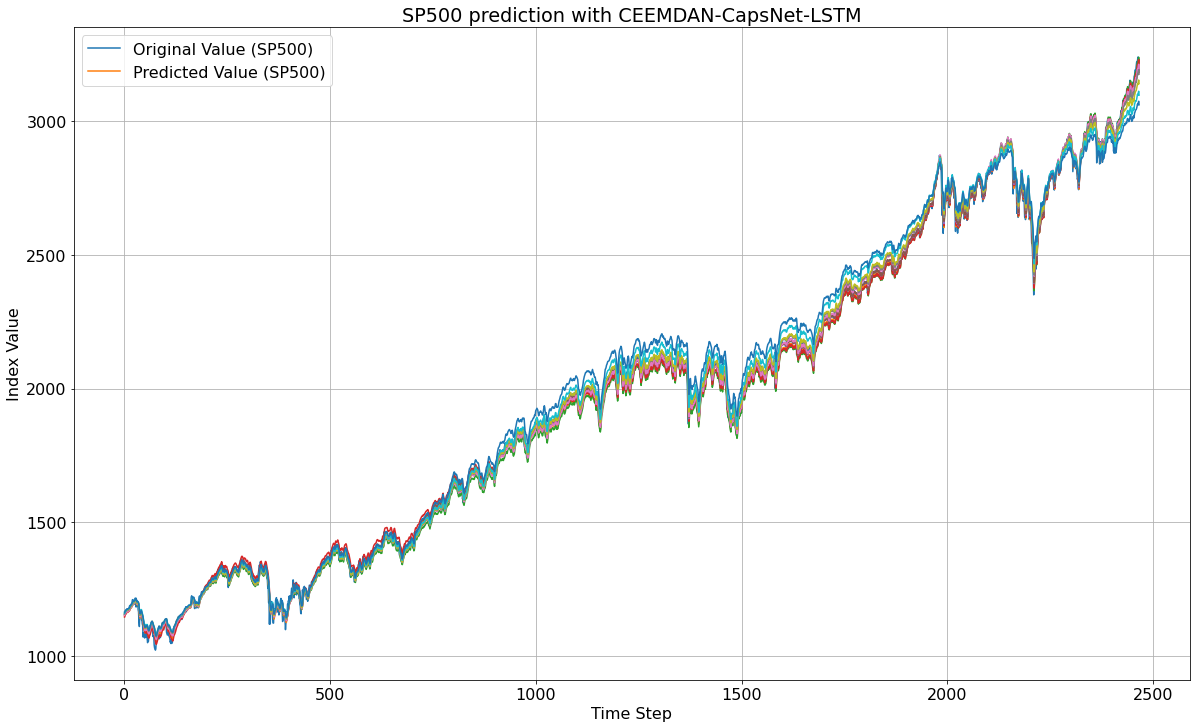

In [79]:
plt.figure(figsize=(20, 12))
plot_series(np.arange( 1, len(series)-G.WINDOW_SIZE+1 ), series_y)
plot_series(np.arange( 1, len(series)-G.WINDOW_SIZE+1 ), series_y_hat_capsnet_lstm)
plt.ylabel("Index Value")
plt.xlabel("Time Step")
plt.title("SP500 prediction with CEEMDAN-CapsNet-LSTM")
legend_drawn_flag = True
plt.legend(["Original Value (SP500)", "Predicted Value (SP500)"], loc=0, frameon=legend_drawn_flag)
plt.savefig("/content/gdrive/MyDrive/Multistage/figures/capsnet_lstm_forecasts_whole_SP500.svg")

In [80]:
series_test = series_y[-G.SPLIT_TIME:]
series_test_hat_capsnet_lstm_1 = series_y_hat_capsnet_lstm[-G.SPLIT_TIME:,0]
series_test_hat_capsnet_lstm_2 = series_y_hat_capsnet_lstm[-G.SPLIT_TIME+1:,1]
series_test_hat_capsnet_lstm_3 = series_y_hat_capsnet_lstm[-G.SPLIT_TIME+2:,2]
series_test_hat_capsnet_lstm_4 = series_y_hat_capsnet_lstm[-G.SPLIT_TIME+3:,3]
series_test_hat_capsnet_lstm_5 = series_y_hat_capsnet_lstm[-G.SPLIT_TIME+4:,4]
series_test_hat_capsnet_lstm_6 = series_y_hat_capsnet_lstm[-G.SPLIT_TIME+5:,5]
series_test_hat_capsnet_lstm_7 = series_y_hat_capsnet_lstm[-G.SPLIT_TIME+6:,6]
series_test_hat_capsnet_lstm_8 = series_y_hat_capsnet_lstm[-G.SPLIT_TIME+7:,7]
series_test_hat_capsnet_lstm_9 = series_y_hat_capsnet_lstm[-G.SPLIT_TIME+8:,8]
series_test_hat_capsnet_lstm_10 = series_y_hat_capsnet_lstm[-G.SPLIT_TIME+9:,9]


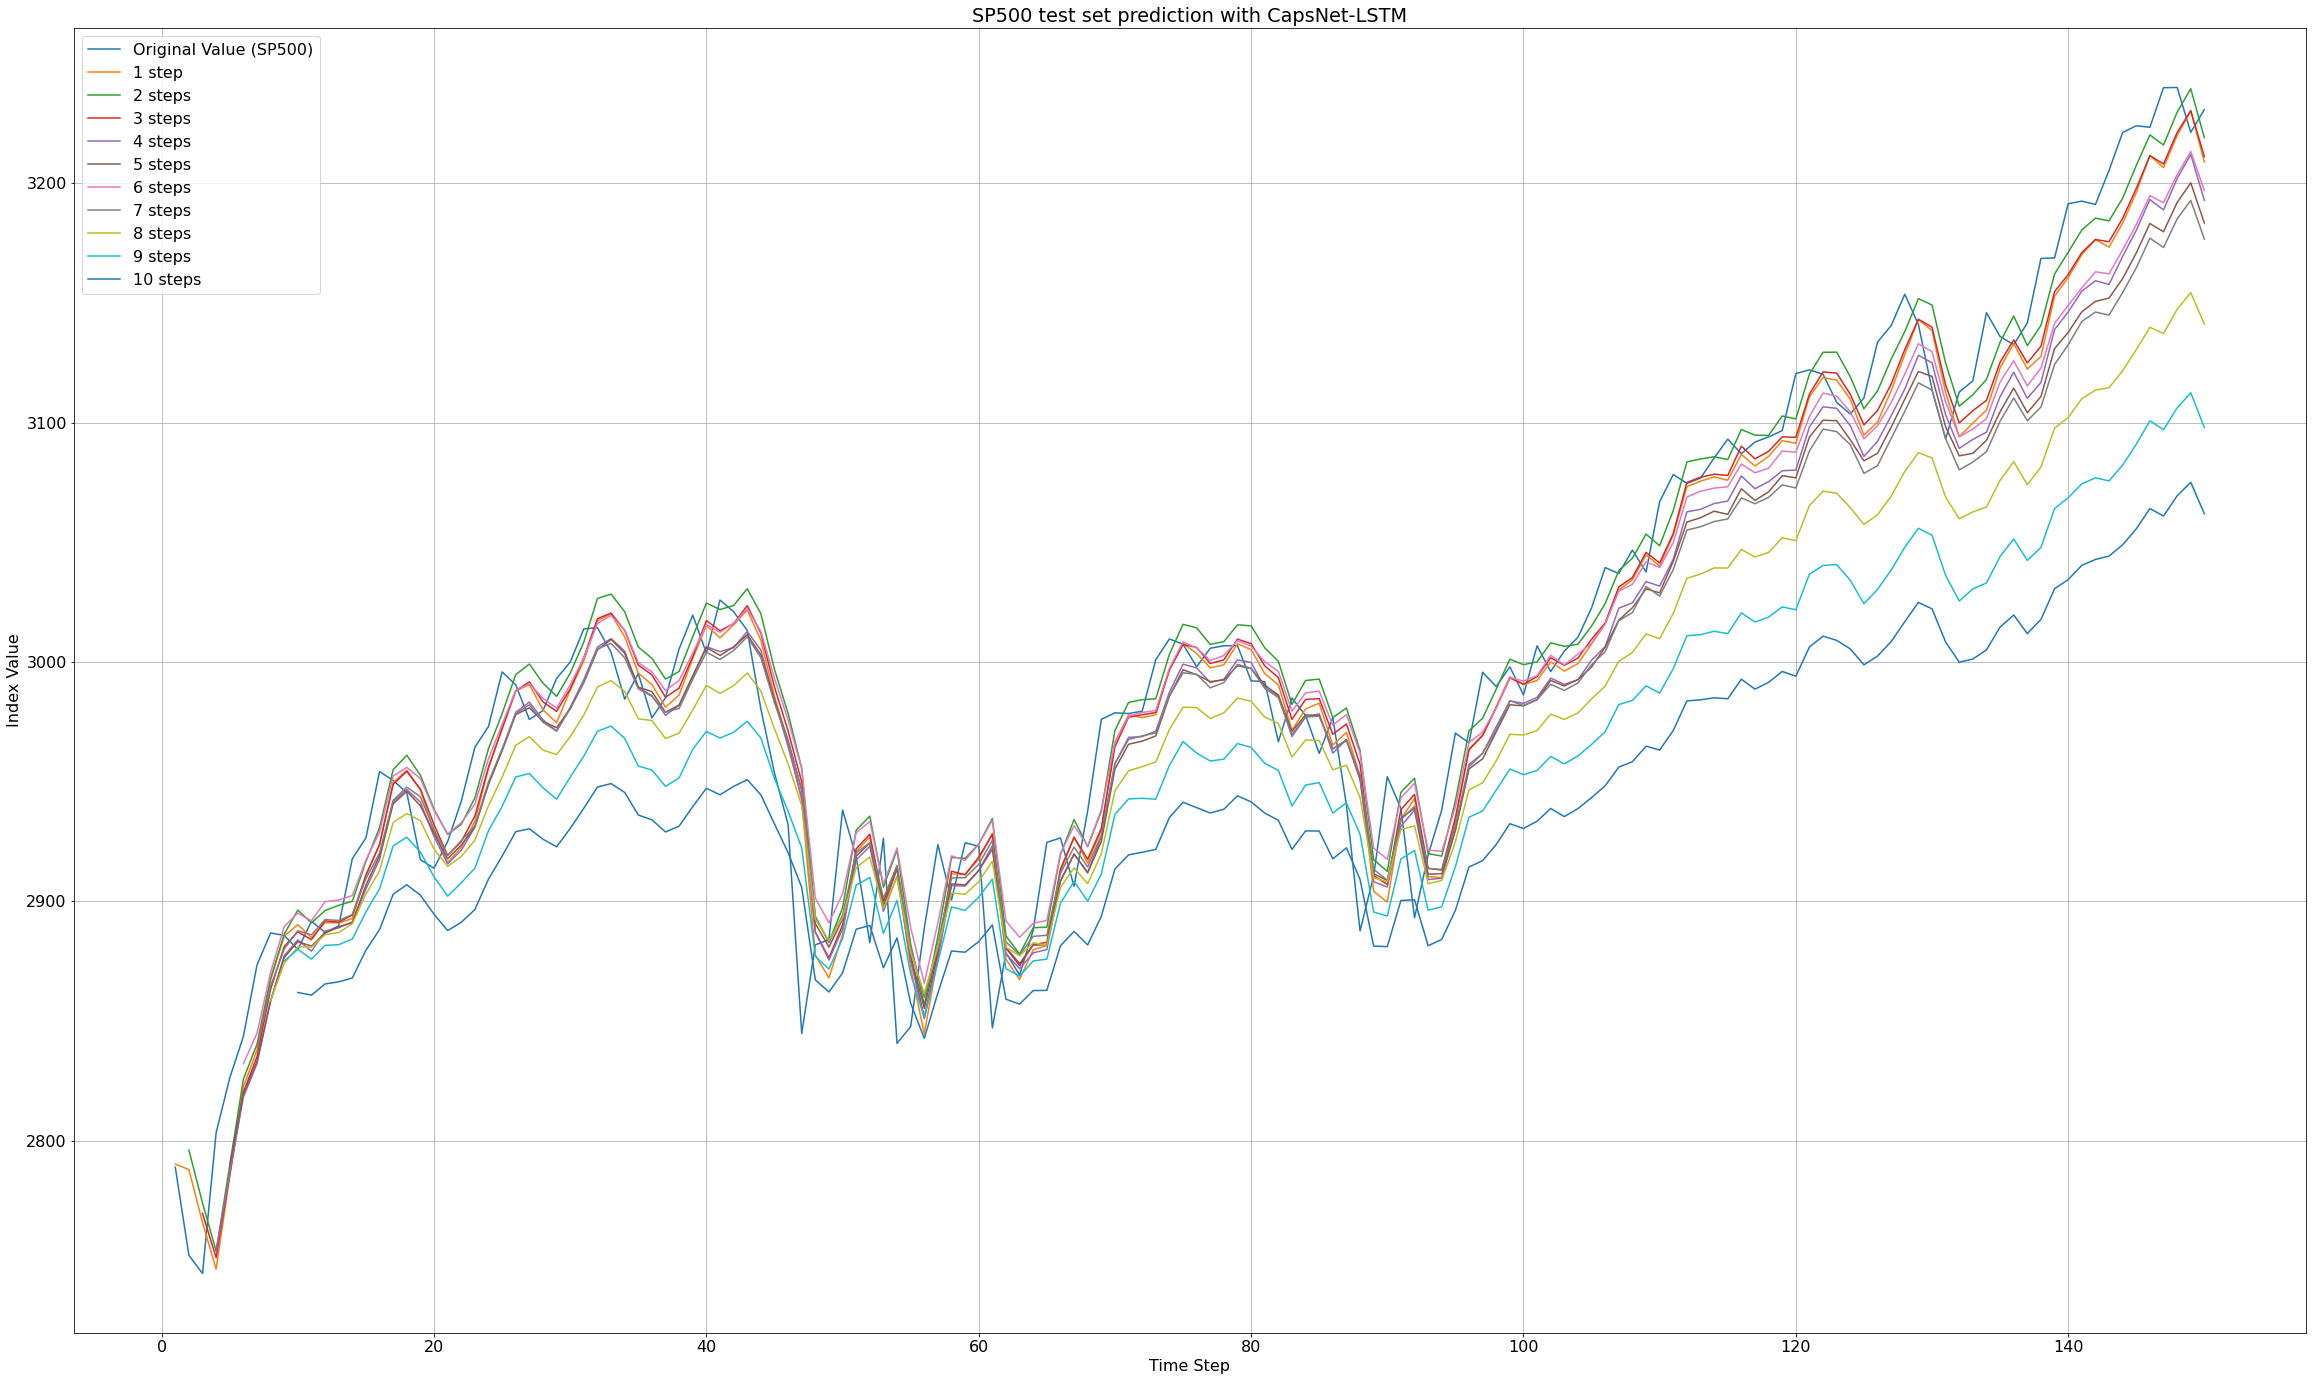

In [81]:
# Plot the forecast

plt.figure(figsize=(40, 24))
plot_series(np.arange( 1, len(time_test)+1 ), series_test)
plot_series(np.arange( 1, len(time_test)+1 ), series_test_hat_capsnet_lstm_1)
plot_series(np.arange( 2, len(time_test)+1 ), series_test_hat_capsnet_lstm_2)
plot_series(np.arange( 3, len(time_test)+1 ), series_test_hat_capsnet_lstm_3)
plot_series(np.arange( 4, len(time_test)+1 ), series_test_hat_capsnet_lstm_4)
plot_series(np.arange( 5, len(time_test)+1 ), series_test_hat_capsnet_lstm_5)
plot_series(np.arange( 6, len(time_test)+1 ), series_test_hat_capsnet_lstm_6)
plot_series(np.arange( 7, len(time_test)+1 ), series_test_hat_capsnet_lstm_7)
plot_series(np.arange( 8, len(time_test)+1 ), series_test_hat_capsnet_lstm_8)
plot_series(np.arange( 9, len(time_test)+1 ), series_test_hat_capsnet_lstm_9)
plot_series(np.arange( 10, len(time_test)+1 ), series_test_hat_capsnet_lstm_10)

plt.ylabel("Index Value")
plt.xlabel("Time Step")
plt.title("SP500 test set prediction with CapsNet-LSTM")
legend_drawn_flag = True
plt.legend(["Original Value (SP500)", "1 step","2 steps","3 steps","4 steps","5 steps","6 steps","7 steps","8 steps","9 steps","10 steps"], loc=0, frameon=legend_drawn_flag)
plt.savefig("/content/gdrive/MyDrive/Multistage/figures/capsnet_lstm_forecasts_10steps_SP500.svg")

In [82]:
rmse_capsnet_lstm_1, mae_capsnet_lstm_1, mape_capsnet_lstm_1= compute_metrics(series_test, series_test_hat_capsnet_lstm_1)

print(f"rmse: {rmse_capsnet_lstm_1:.2f}, mae: {mae_capsnet_lstm_1:.2f} , mape: {mape_capsnet_lstm_1:.2f} for 1 step forecast")

rmse: 25.04, mae: 18.76 , mape: 0.63 for 1 step forecast


In [83]:
rmse_capsnet_lstm_2, mae_capsnet_lstm_2, mape_capsnet_lstm_2= compute_metrics(series_test[1:], series_test_hat_capsnet_lstm_2)

print(f"rmse: {rmse_capsnet_lstm_2:.2f}, mae: {mae_capsnet_lstm_2:.2f} , mape: {mape_capsnet_lstm_2:.2f} for 2 steps forecast")

rmse: 24.81, mae: 17.69 , mape: 0.60 for 2 steps forecast


In [84]:
rmse_capsnet_lstm_3, mae_capsnet_lstm_3, mape_capsnet_lstm_3= compute_metrics(series_test[2:], series_test_hat_capsnet_lstm_3)

print(f"rmse: {rmse_capsnet_lstm_3:.2f}, mae: {mae_capsnet_lstm_3:.2f} , mape: {mape_capsnet_lstm_3:.2f} for 3 steps forecast")

rmse: 24.76, mae: 18.30 , mape: 0.61 for 3 steps forecast


In [85]:
rmse_capsnet_lstm_4, mae_capsnet_lstm_4, mape_capsnet_lstm_4= compute_metrics(series_test[3:], series_test_hat_capsnet_lstm_4)

print(f"rmse: {rmse_capsnet_lstm_4:.2f}, mae: {mae_capsnet_lstm_4:.2f} , mape: {mape_capsnet_lstm_4:.2f} for 4 steps forecast")

rmse: 28.20, mae: 22.62 , mape: 0.75 for 4 steps forecast


In [86]:
rmse_capsnet_lstm_5, mae_capsnet_lstm_5, mape_capsnet_lstm_5= compute_metrics(series_test[4:], series_test_hat_capsnet_lstm_5)

print(f"rmse: {rmse_capsnet_lstm_5:.2f}, mae: {mae_capsnet_lstm_5:.2f} , mape: {mape_capsnet_lstm_5:.2f} for 5 steps forecast")

rmse: 29.81, mae: 23.95 , mape: 0.79 for 5 steps forecast


In [87]:
rmse_capsnet_lstm_6, mae_capsnet_lstm_6, mape_capsnet_lstm_6= compute_metrics(series_test[5:], series_test_hat_capsnet_lstm_6)

print(f"rmse: {rmse_capsnet_lstm_6:.2f}, mae: {mae_capsnet_lstm_6:.2f} , mape: {mape_capsnet_lstm_6:.2f} for 6 steps forecast")

rmse: 26.29, mae: 19.54 , mape: 0.65 for 6 steps forecast


In [88]:
rmse_capsnet_lstm_7, mae_capsnet_lstm_7, mape_capsnet_lstm_7= compute_metrics(series_test[6:], series_test_hat_capsnet_lstm_7)

print(f"rmse: {rmse_capsnet_lstm_7:.2f}, mae: {mae_capsnet_lstm_7:.2f} , mape: {mape_capsnet_lstm_7:.2f} for 7 steps forecast")

rmse: 31.18, mae: 24.82 , mape: 0.82 for 7 steps forecast


In [89]:
rmse_capsnet_lstm_8, mae_capsnet_lstm_8, mape_capsnet_lstm_8= compute_metrics(series_test[7:], series_test_hat_capsnet_lstm_8)

print(f"rmse: {rmse_capsnet_lstm_8:.2f}, mae: {mae_capsnet_lstm_8:.2f} , mape: {mape_capsnet_lstm_8:.2f} for 8 steps forecast")

rmse: 43.71, mae: 35.99 , mape: 1.18 for 8 steps forecast


In [90]:
rmse_capsnet_lstm_9, mae_capsnet_lstm_9, mape_capsnet_lstm_9= compute_metrics(series_test[8:], series_test_hat_capsnet_lstm_9)

print(f"rmse: {rmse_capsnet_lstm_9:.2f}, mae: {mae_capsnet_lstm_9:.2f} , mape: {mape_capsnet_lstm_9:.2f} for 9 steps forecast")

rmse: 62.34, mae: 52.04 , mape: 1.70 for 9 steps forecast


In [91]:
rmse_capsnet_lstm_10, mae_capsnet_lstm_10, mape_capsnet_lstm_10= compute_metrics(series_test[9:], series_test_hat_capsnet_lstm_10)

print(f"rmse: {rmse_capsnet_lstm_10:.2f}, mae: {mae_capsnet_lstm_10:.2f} , mape: {mape_capsnet_lstm_10:.2f} for 10 steps forecast")

rmse: 83.60, mae: 72.86 , mape: 2.38 for 10 steps forecast


In [93]:
# Save_weights model

capsnet_lstm.save_weights("/content/gdrive/MyDrive/Multistage/models/capsnet_lstm_SP500_MIMO.h5", overwrite=True, save_format=None, options=None)


In [95]:
# Save predicted values

np.savetxt("/content/gdrive/MyDrive/Multistage/files/capsnet_lstm_predicted_test_SP500_1.csv", 
           series_test_hat_capsnet_lstm_1.T, delimiter=",")
np.savetxt("/content/gdrive/MyDrive/Multistage/files/capsnet_lstm_predicted_test_SP500_2.csv", 
           series_test_hat_capsnet_lstm_2.T, delimiter=",")
np.savetxt("/content/gdrive/MyDrive/Multistage/files/capsnet_lstm_predicted_test_SP500_3.csv", 
           series_test_hat_capsnet_lstm_3.T, delimiter=",")
np.savetxt("/content/gdrive/MyDrive/Multistage/files/capsnet_lstm_predicted_test_SP500_4.csv", 
           series_test_hat_capsnet_lstm_4.T, delimiter=",")
np.savetxt("/content/gdrive/MyDrive/Multistage/files/capsnet_lstm_predicted_test_SP500_5.csv", 
           series_test_hat_capsnet_lstm_5.T, delimiter=",")
np.savetxt("/content/gdrive/MyDrive/Multistage/files/capsnet_lstm_predicted_test_SP500_6.csv", 
           series_test_hat_capsnet_lstm_6.T, delimiter=",")
np.savetxt("/content/gdrive/MyDrive/Multistage/files/capsnet_lstm_predicted_test_SP500_7.csv", 
           series_test_hat_capsnet_lstm_7.T, delimiter=",")
np.savetxt("/content/gdrive/MyDrive/Multistage/files/capsnet_lstm_predicted_test_SP500_8.csv", 
           series_test_hat_capsnet_lstm_8.T, delimiter=",")
np.savetxt("/content/gdrive/MyDrive/Multistage/files/capsnet_lstm_predicted_test_SP500_9.csv", 
           series_test_hat_capsnet_lstm_9.T, delimiter=",")
np.savetxt("/content/gdrive/MyDrive/Multistage/files/capsnet_lstm_predicted_test_SP500_10.csv", 
           series_test_hat_capsnet_lstm_10.T, delimiter=",")


np.savetxt("/content/gdrive/MyDrive/Multistage/files/capsnet_lstm_predicted_whole_SP500.csv", 
           series_y_hat_capsnet_lstm.T, delimiter=",")

# Baseline (LSTM, CNN-LSTM)

## LSTM

In [135]:
# Build the model with the best hp.
def LSTM():
   
    model = tf.keras.models.Sequential([
          tf.keras.layers.LSTM(200, input_shape=[G.WINDOW_SIZE, 1]),
          tf.keras.layers.Dense(10)
    ])
    learning_rate = 0.0005
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss=tf.keras.losses.MeanSquaredError(),
        metrics=["mae"])

    return model

### Model training

In [136]:

with strategy.scope():
  lstm = LSTM()
    # Fit with the entire dataset.
lstm.fit(train_set_ten_step, epochs=200,callbacks = [reduce_lr])  


Epoch 1/200
73/73 [==============================] - 11s 43ms/step - loss: 0.0037 - mae: 0.0434 - lr: 5.0000e-04
Epoch 2/200
73/73 [==============================] - 2s 34ms/step - loss: 0.0082 - mae: 0.0688 - lr: 5.0000e-04
Epoch 3/200
73/73 [==============================] - 2s 26ms/step - loss: 0.0051 - mae: 0.0562 - lr: 5.0000e-04
Epoch 4/200
73/73 [==============================] - 2s 28ms/step - loss: 0.0030 - mae: 0.0439 - lr: 5.0000e-04
Epoch 5/200
73/73 [==============================] - 2s 27ms/step - loss: 0.0016 - mae: 0.0319 - lr: 5.0000e-04
Epoch 6/200
73/73 [==============================] - 2s 30ms/step - loss: 8.4821e-04 - mae: 0.0218 - lr: 5.0000e-04
Epoch 7/200
73/73 [==============================] - 2s 34ms/step - loss: 7.7486e-04 - mae: 0.0202 - lr: 5.0000e-04
Epoch 8/200
73/73 [==============================] - 2s 25ms/step - loss: 7.8626e-04 - mae: 0.0204 - lr: 5.0000e-04
Epoch 9/200
73/73 [==============================] - 2s 25ms/step - loss: 7.8322e-04 - mae:

In [137]:
print(lstm.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 200)               161600    
                                                                 
 dense_2 (Dense)             (None, 10)                2010      
                                                                 
Total params: 163,610
Trainable params: 163,610
Non-trainable params: 0
_________________________________________________________________
None


### Evaluating the forecast

Now it is time to evaluate the performance of the forecast. For this we use the `compute_metrics` function:

At this point only the model that will perform the forecast is ready but we still need to compute the actual forecast.



Faster model forecasts


- The dataset is windowed using `window_size` rather than `window_size + 1`
- No shuffle should be used
- No need to split the data into features and labels
- A model is used to predict batches of the dataset

Now compute the actual forecast:

In [138]:
# Evaluate each model and the ensemble on the test set
# remember the last predicted value is not in the test set. It should be removed when producing y_hat series.

lstm_pred =  model_forecast(lstm, series_norm, G.WINDOW_SIZE).squeeze()



78/78 [==============================] - 9s 24ms/step


In [139]:
lstm_pred = reverse_normalization(lstm_pred, series_train)


In [140]:
series_hat_lstm = lstm_pred

In [141]:
series_y_hat_lstm = np.array(list(series_hat_lstm[:-1]))

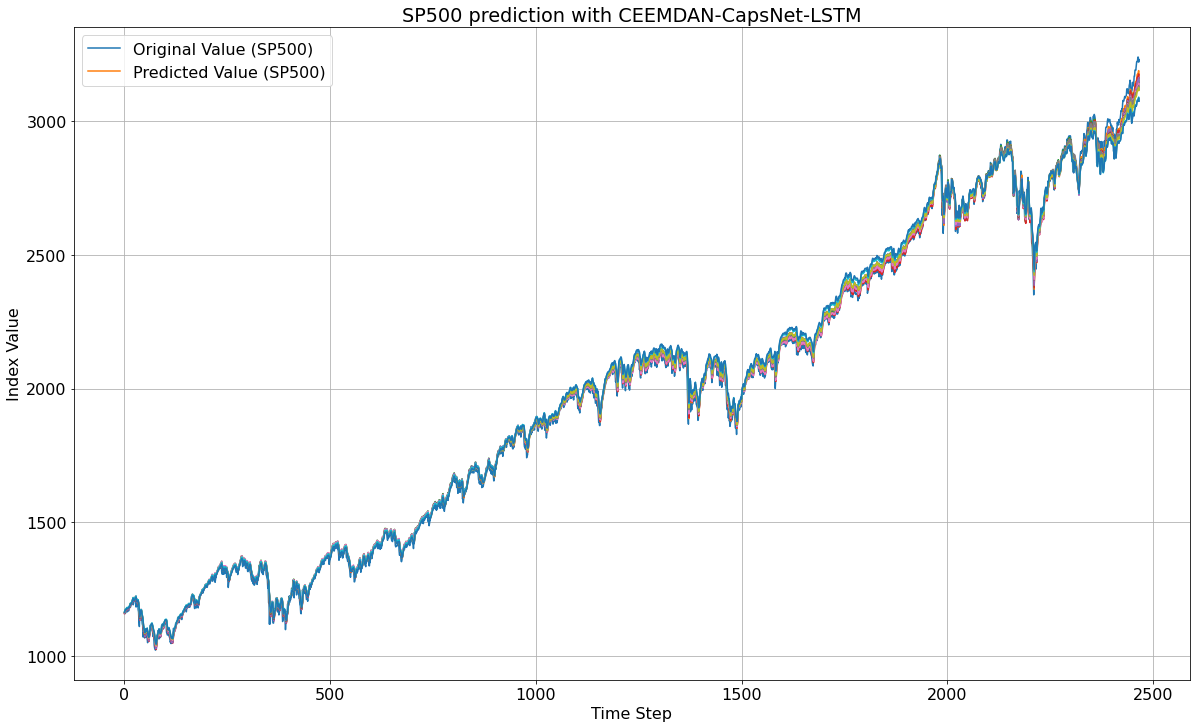

In [142]:
plt.figure(figsize=(20, 12))
plot_series(np.arange( 1, len(series)-G.WINDOW_SIZE+1 ), series_y)
plot_series(np.arange( 1, len(series)-G.WINDOW_SIZE+1 ), series_y_hat_lstm)
plt.ylabel("Index Value")
plt.xlabel("Time Step")
plt.title("SP500 prediction with CEEMDAN-CapsNet-LSTM")
legend_drawn_flag = True
plt.legend(["Original Value (SP500)", "Predicted Value (SP500)"], loc=0, frameon=legend_drawn_flag)
plt.savefig("/content/gdrive/MyDrive/Multistage/figures/lstm_forecasts_whole_SP500.svg")

In [143]:
series_test = series_y[-G.SPLIT_TIME:]
series_test_hat_lstm_1 = series_y_hat_lstm[-G.SPLIT_TIME:,0]
series_test_hat_lstm_2 = series_y_hat_lstm[-G.SPLIT_TIME+1:,1]
series_test_hat_lstm_3 = series_y_hat_lstm[-G.SPLIT_TIME+2:,2]
series_test_hat_lstm_4 = series_y_hat_lstm[-G.SPLIT_TIME+3:,3]
series_test_hat_lstm_5 = series_y_hat_lstm[-G.SPLIT_TIME+4:,4]
series_test_hat_lstm_6 = series_y_hat_lstm[-G.SPLIT_TIME+5:,5]
series_test_hat_lstm_7 = series_y_hat_lstm[-G.SPLIT_TIME+6:,6]
series_test_hat_lstm_8 = series_y_hat_lstm[-G.SPLIT_TIME+7:,7]
series_test_hat_lstm_9 = series_y_hat_lstm[-G.SPLIT_TIME+8:,8]
series_test_hat_lstm_10 = series_y_hat_lstm[-G.SPLIT_TIME+9:,9]


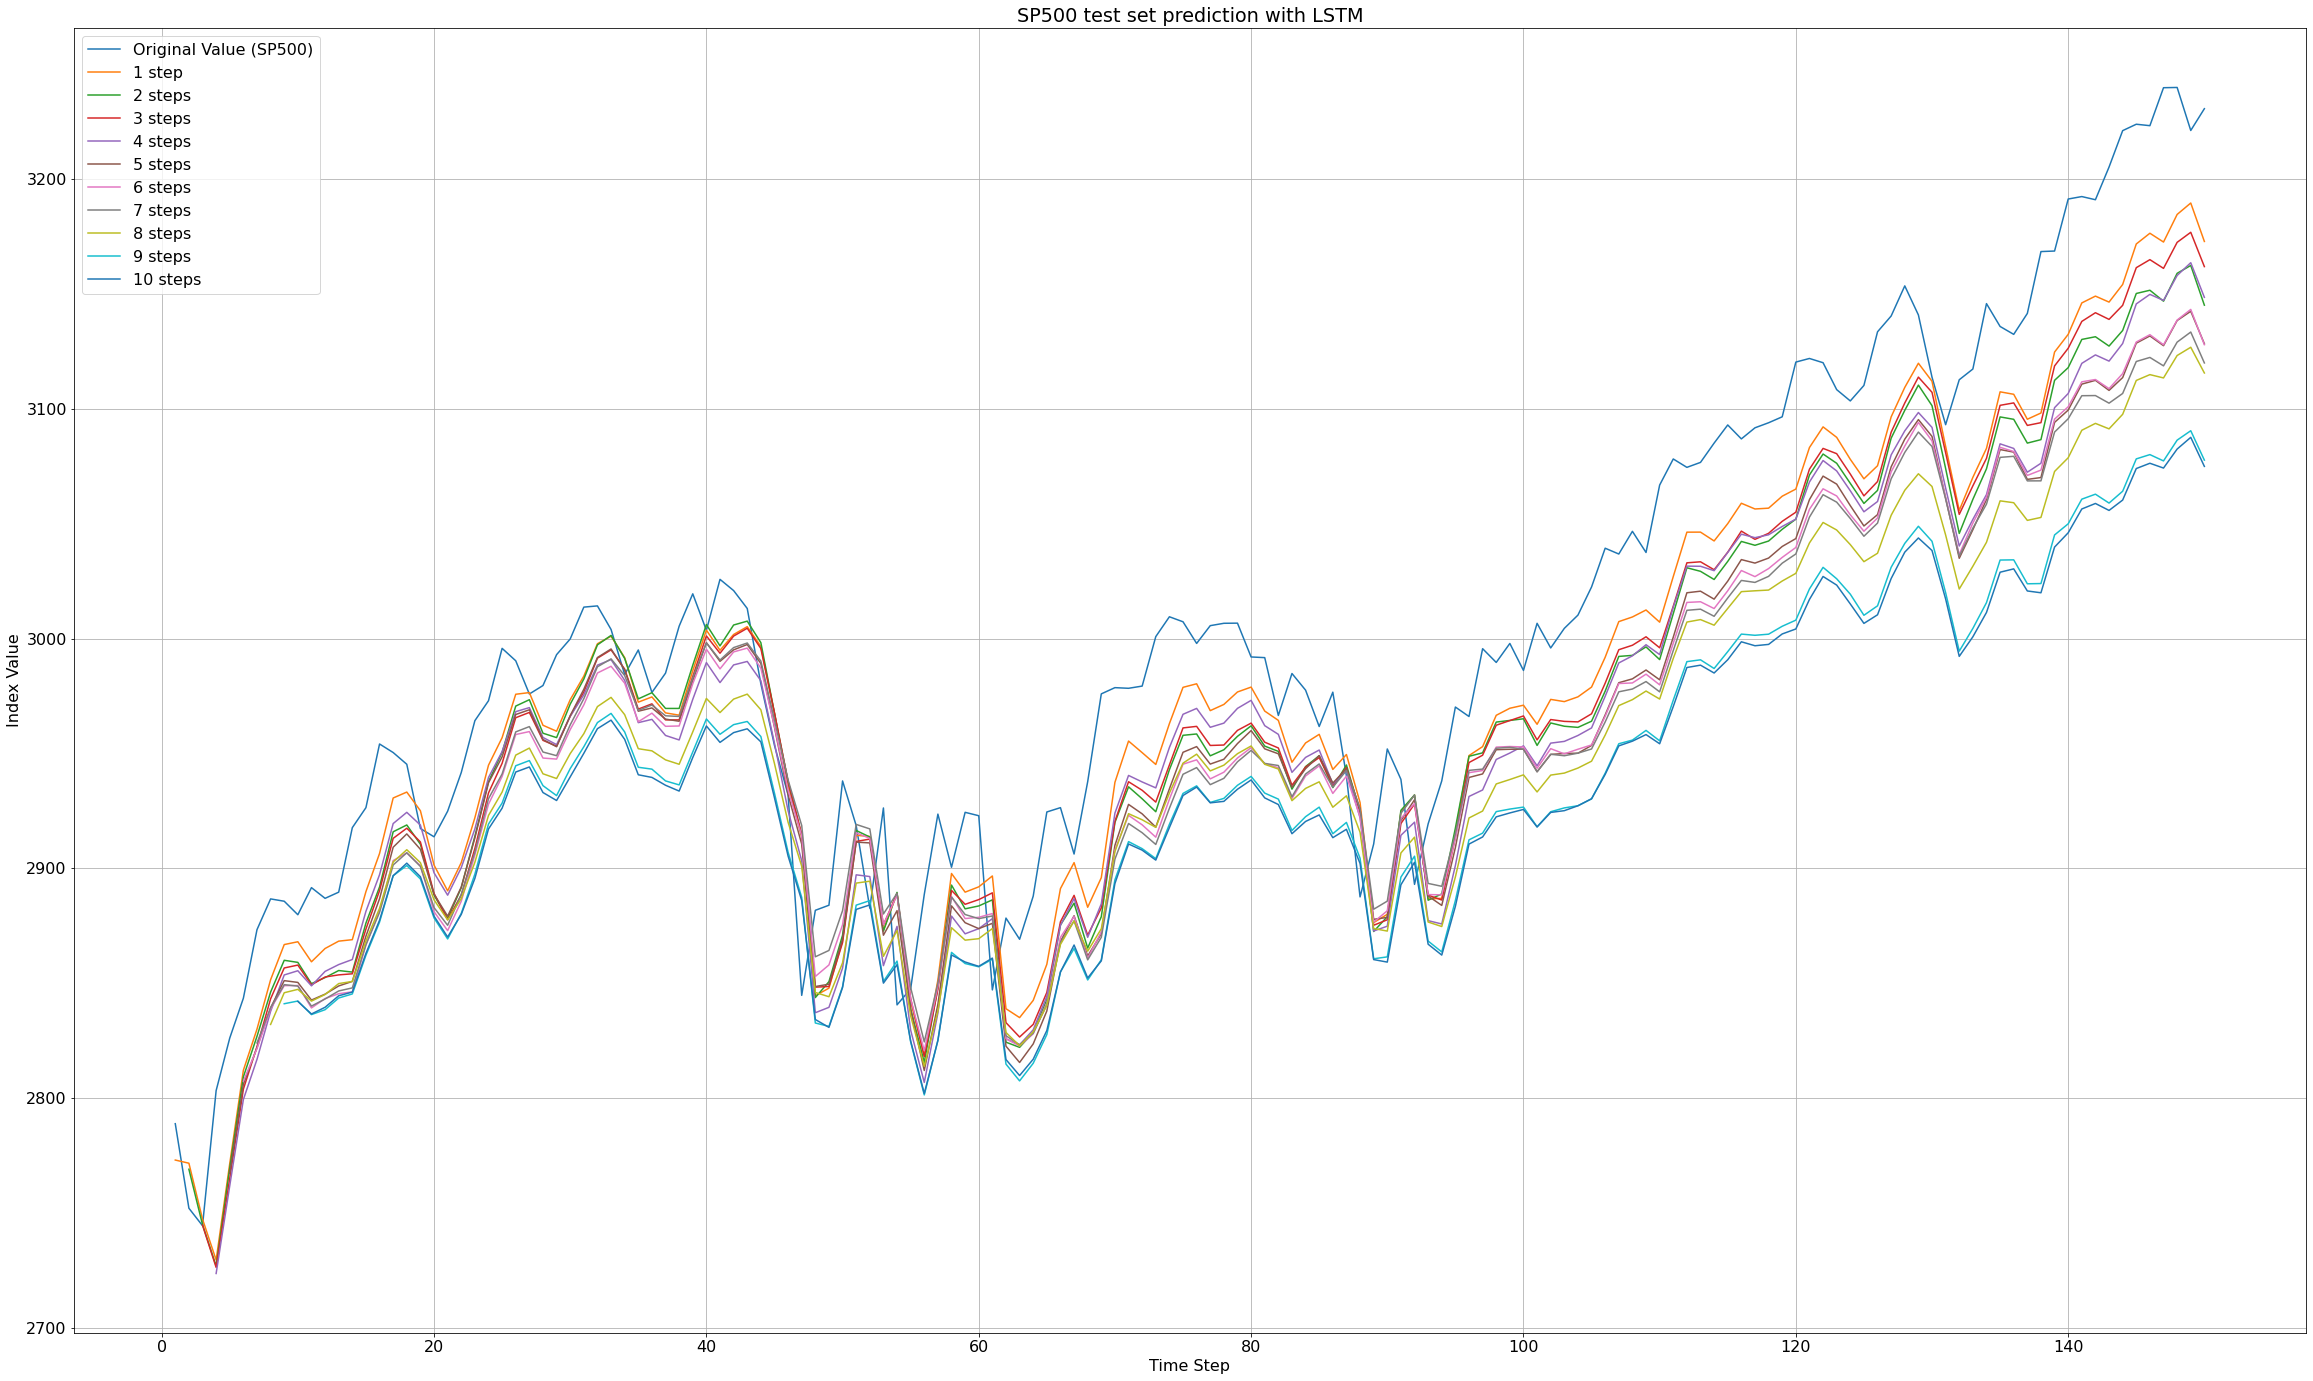

In [144]:
# Plot the forecast

plt.figure(figsize=(40, 24))
plot_series(np.arange( 1, len(time_test)+1 ), series_test)
plot_series(np.arange( 1, len(time_test)+1 ), series_test_hat_lstm_1)
plot_series(np.arange( 2, len(time_test)+1 ), series_test_hat_lstm_2)
plot_series(np.arange( 3, len(time_test)+1 ), series_test_hat_lstm_3)
plot_series(np.arange( 4, len(time_test)+1 ), series_test_hat_lstm_4)
plot_series(np.arange( 5, len(time_test)+1 ), series_test_hat_lstm_5)
plot_series(np.arange( 6, len(time_test)+1 ), series_test_hat_lstm_6)
plot_series(np.arange( 7, len(time_test)+1 ), series_test_hat_lstm_7)
plot_series(np.arange( 8, len(time_test)+1 ), series_test_hat_lstm_8)
plot_series(np.arange( 9, len(time_test)+1 ), series_test_hat_lstm_9)
plot_series(np.arange( 10, len(time_test)+1 ), series_test_hat_lstm_10)

plt.ylabel("Index Value")
plt.xlabel("Time Step")
plt.title("SP500 test set prediction with LSTM")
legend_drawn_flag = True
plt.legend(["Original Value (SP500)", "1 step","2 steps","3 steps","4 steps","5 steps","6 steps","7 steps","8 steps","9 steps","10 steps"], loc=0, frameon=legend_drawn_flag)
plt.savefig("/content/gdrive/MyDrive/Multistage/figures/lstm_forecasts_10steps_SP500.svg")

In [145]:
rmse_lstm_1, mae_lstm_1, mape_lstm_1= compute_metrics(series_test, series_test_hat_lstm_1)

print(f"rmse: {rmse_lstm_1:.2f}, mae: {mae_lstm_1:.2f} , mape: {mape_lstm_1:.2f} for 1 step forecast")

rmse: 38.64, mae: 33.97 , mape: 1.13 for 1 step forecast


In [146]:
rmse_lstm_2, mae_lstm_2, mape_lstm_2= compute_metrics(series_test[1:], series_test_hat_lstm_2)

print(f"rmse: {rmse_lstm_2:.2f}, mae: {mae_lstm_2:.2f} , mape: {mape_lstm_2:.2f} for 2 steps forecast")

rmse: 48.42, mae: 43.22 , mape: 1.43 for 2 steps forecast


In [147]:
rmse_lstm_3, mae_lstm_3, mape_lstm_3= compute_metrics(series_test[2:], series_test_hat_lstm_3)

print(f"rmse: {rmse_lstm_3:.2f}, mae: {mae_lstm_3:.2f} , mape: {mape_lstm_3:.2f} for 3 steps forecast")

rmse: 46.17, mae: 41.78 , mape: 1.39 for 3 steps forecast


In [148]:
rmse_lstm_4, mae_lstm_4, mape_lstm_4= compute_metrics(series_test[3:], series_test_hat_lstm_4)

print(f"rmse: {rmse_lstm_4:.2f}, mae: {mae_lstm_4:.2f} , mape: {mape_lstm_4:.2f} for 4 steps forecast")

rmse: 51.01, mae: 46.12 , mape: 1.53 for 4 steps forecast


In [149]:
rmse_lstm_5, mae_lstm_5, mape_lstm_5= compute_metrics(series_test[4:], series_test_hat_lstm_5)

print(f"rmse: {rmse_lstm_5:.2f}, mae: {mae_lstm_5:.2f} , mape: {mape_lstm_5:.2f} for 5 steps forecast")

rmse: 56.04, mae: 50.29 , mape: 1.66 for 5 steps forecast


In [150]:
rmse_lstm_6, mae_lstm_6, mape_lstm_6= compute_metrics(series_test[5:], series_test_hat_lstm_6)

print(f"rmse: {rmse_lstm_6:.2f}, mae: {mae_lstm_6:.2f} , mape: {mape_lstm_6:.2f} for 6 steps forecast")

rmse: 57.14, mae: 51.79 , mape: 1.71 for 6 steps forecast


In [151]:
rmse_lstm_7, mae_lstm_7, mape_lstm_7= compute_metrics(series_test[6:], series_test_hat_lstm_7)

print(f"rmse: {rmse_lstm_7:.2f}, mae: {mae_lstm_7:.2f} , mape: {mape_lstm_7:.2f} for 7 steps forecast")

rmse: 59.01, mae: 52.80 , mape: 1.74 for 7 steps forecast


In [152]:
rmse_lstm_8, mae_lstm_8, mape_lstm_8= compute_metrics(series_test[7:], series_test_hat_lstm_8)

print(f"rmse: {rmse_lstm_8:.2f}, mae: {mae_lstm_8:.2f} , mape: {mape_lstm_8:.2f} for 8 steps forecast")

rmse: 65.66, mae: 60.17 , mape: 1.98 for 8 steps forecast


In [153]:
rmse_lstm_9, mae_lstm_9, mape_lstm_9= compute_metrics(series_test[8:], series_test_hat_lstm_9)

print(f"rmse: {rmse_lstm_9:.2f}, mae: {mae_lstm_9:.2f} , mape: {mape_lstm_9:.2f} for 9 steps forecast")

rmse: 81.57, mae: 74.18 , mape: 2.44 for 9 steps forecast


In [154]:
rmse_lstm_10, mae_lstm_10, mape_lstm_10= compute_metrics(series_test[9:], series_test_hat_lstm_10)

print(f"rmse: {rmse_lstm_10:.2f}, mae: {mae_lstm_10:.2f} , mape: {mape_lstm_10:.2f} for 10 steps forecast")

rmse: 83.71, mae: 76.10 , mape: 2.50 for 10 steps forecast


In [155]:
# Save_weights model

lstm.save_weights("/content/gdrive/MyDrive/Multistage/models/lstm_SP500_MIMO.h5", overwrite=True, save_format=None, options=None)


In [156]:
# Save predicted values

np.savetxt("/content/gdrive/MyDrive/Multistage/files/lstm_predicted_test_SP500_1.csv", 
           series_test_hat_lstm_1.T, delimiter=",")
np.savetxt("/content/gdrive/MyDrive/Multistage/files/lstm_predicted_test_SP500_2.csv", 
           series_test_hat_lstm_2.T, delimiter=",")
np.savetxt("/content/gdrive/MyDrive/Multistage/files/lstm_predicted_test_SP500_3.csv", 
           series_test_hat_lstm_3.T, delimiter=",")
np.savetxt("/content/gdrive/MyDrive/Multistage/files/lstm_predicted_test_SP500_4.csv", 
           series_test_hat_lstm_4.T, delimiter=",")
np.savetxt("/content/gdrive/MyDrive/Multistage/files/lstm_predicted_test_SP500_5.csv", 
           series_test_hat_lstm_5.T, delimiter=",")
np.savetxt("/content/gdrive/MyDrive/Multistage/files/lstm_predicted_test_SP500_6.csv", 
           series_test_hat_lstm_6.T, delimiter=",")
np.savetxt("/content/gdrive/MyDrive/Multistage/files/lstm_predicted_test_SP500_7.csv", 
           series_test_hat_lstm_7.T, delimiter=",")
np.savetxt("/content/gdrive/MyDrive/Multistage/files/lstm_predicted_test_SP500_8.csv", 
           series_test_hat_lstm_8.T, delimiter=",")
np.savetxt("/content/gdrive/MyDrive/Multistage/files/lstm_predicted_test_SP500_9.csv", 
           series_test_hat_lstm_9.T, delimiter=",")
np.savetxt("/content/gdrive/MyDrive/Multistage/files/lstm_predicted_test_SP500_10.csv", 
           series_test_hat_lstm_10.T, delimiter=",")


np.savetxt("/content/gdrive/MyDrive/Multistage/files/lstm_predicted_whole_SP500.csv", 
           series_y_hat_lstm.T, delimiter=",")

## CNN-LSTM

In [158]:
def CNN_LSTM():
   
    model = tf.keras.models.Sequential([
          tf.keras.layers.Conv1D(filters=256, kernel_size=2,
                                 strides=1,
                                 activation="relu",
                                 padding='causal',
                                 input_shape=[G.WINDOW_SIZE, 1]),
          tf.keras.layers.MaxPooling1D(pool_size=2, strides=1, padding="same"),
          tf.keras.layers.LSTM(200),
          tf.keras.layers.Dense(10)
    ])
    learning_rate = 0.0005
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
        loss=tf.keras.losses.MeanSquaredError(),
        metrics=["mae"])

    return model

### Model training

In [159]:

with strategy.scope():
  cnn_lstm = CNN_LSTM()
    # Fit with the entire dataset.
cnn_lstm.fit(train_set_ten_step, epochs=200,callbacks = [reduce_lr])  


Epoch 1/200
73/73 [==============================] - 9s 40ms/step - loss: 0.0025 - mae: 0.0374 - lr: 5.0000e-04
Epoch 2/200
73/73 [==============================] - 2s 22ms/step - loss: 0.0033 - mae: 0.0430 - lr: 5.0000e-04
Epoch 3/200
73/73 [==============================] - 2s 21ms/step - loss: 0.0018 - mae: 0.0324 - lr: 5.0000e-04
Epoch 4/200
73/73 [==============================] - 2s 21ms/step - loss: 8.4086e-04 - mae: 0.0223 - lr: 5.0000e-04
Epoch 5/200
73/73 [==============================] - 2s 22ms/step - loss: 6.7711e-04 - mae: 0.0187 - lr: 5.0000e-04
Epoch 6/200
73/73 [==============================] - 2s 23ms/step - loss: 7.0956e-04 - mae: 0.0193 - lr: 5.0000e-04
Epoch 7/200
73/73 [==============================] - 2s 21ms/step - loss: 7.3734e-04 - mae: 0.0199 - lr: 5.0000e-04
Epoch 8/200
73/73 [==============================] - 2s 22ms/step - loss: 7.5527e-04 - mae: 0.0202 - lr: 5.0000e-04
Epoch 9/200
73/73 [==============================] - 2s 22ms/step - loss: 7.6903e-04

In [160]:
print(cnn_lstm.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 50, 256)           768       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 50, 256)          0         
 )                                                               
                                                                 
 lstm_3 (LSTM)               (None, 200)               365600    
                                                                 
 dense_3 (Dense)             (None, 10)                2010      
                                                                 
Total params: 368,378
Trainable params: 368,378
Non-trainable params: 0
_________________________________________________________________
None


### Evaluating the forecast

Now it is time to evaluate the performance of the forecast. For this we use the `compute_metrics` function:

At this point only the model that will perform the forecast is ready but we still need to compute the actual forecast.



Faster model forecasts


- The dataset is windowed using `window_size` rather than `window_size + 1`
- No shuffle should be used
- No need to split the data into features and labels
- A model is used to predict batches of the dataset

Now compute the actual forecast:

In [161]:
# Evaluate each model and the ensemble on the test set
# remember the last predicted value is not in the test set. It should be removed when producing y_hat series.

cnn_lstm_pred =  model_forecast(cnn_lstm, series_norm, G.WINDOW_SIZE).squeeze()



78/78 [==============================] - 6s 21ms/step


In [162]:
cnn_lstm_pred = reverse_normalization(cnn_lstm_pred, series_train)


In [163]:
series_hat_cnn_lstm = cnn_lstm_pred

In [164]:
series_y_hat_cnn_lstm = np.array(list(series_hat_cnn_lstm[:-1]))

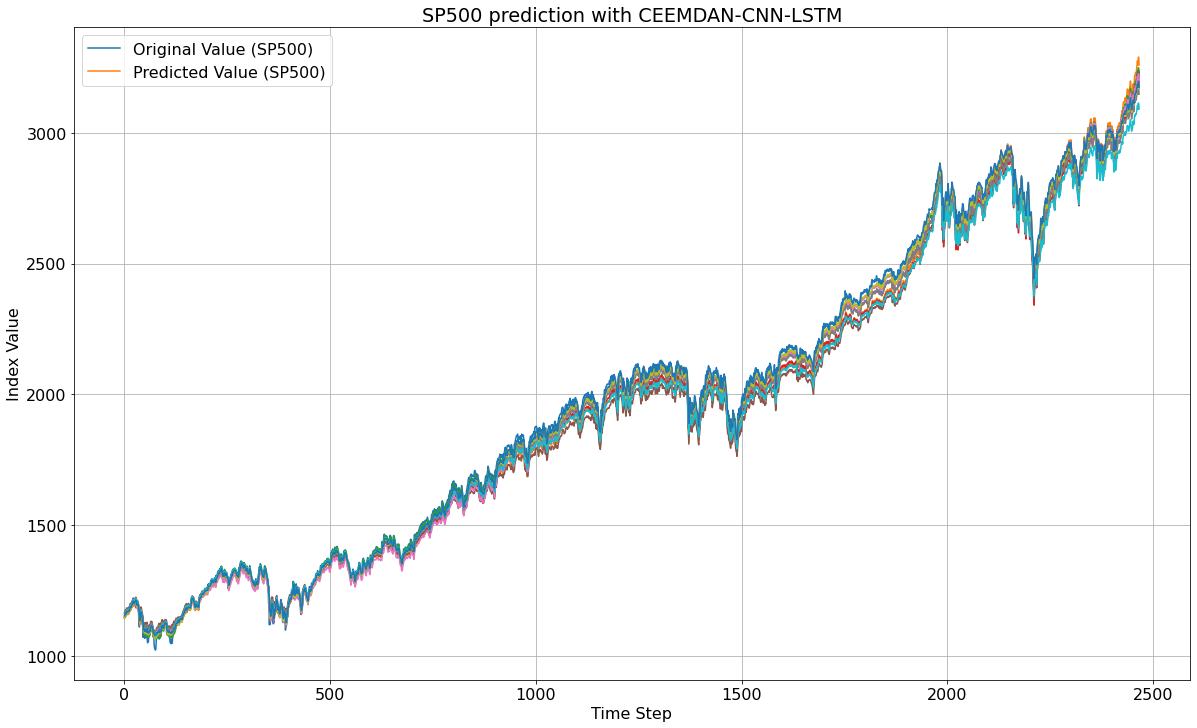

In [165]:
plt.figure(figsize=(20, 12))
plot_series(np.arange( 1, len(series)-G.WINDOW_SIZE+1 ), series_y)
plot_series(np.arange( 1, len(series)-G.WINDOW_SIZE+1 ), series_y_hat_cnn_lstm)
plt.ylabel("Index Value")
plt.xlabel("Time Step")
plt.title("SP500 prediction with CEEMDAN-CNN-LSTM")
legend_drawn_flag = True
plt.legend(["Original Value (SP500)", "Predicted Value (SP500)"], loc=0, frameon=legend_drawn_flag)
plt.savefig("/content/gdrive/MyDrive/Multistage/figures/cnn_lstm_forecasts_whole_SP500.svg")

In [166]:
series_test = series_y[-G.SPLIT_TIME:]
series_test_hat_cnn_lstm_1 = series_y_hat_cnn_lstm[-G.SPLIT_TIME:,0]
series_test_hat_cnn_lstm_2 = series_y_hat_cnn_lstm[-G.SPLIT_TIME+1:,1]
series_test_hat_cnn_lstm_3 = series_y_hat_cnn_lstm[-G.SPLIT_TIME+2:,2]
series_test_hat_cnn_lstm_4 = series_y_hat_cnn_lstm[-G.SPLIT_TIME+3:,3]
series_test_hat_cnn_lstm_5 = series_y_hat_cnn_lstm[-G.SPLIT_TIME+4:,4]
series_test_hat_cnn_lstm_6 = series_y_hat_cnn_lstm[-G.SPLIT_TIME+5:,5]
series_test_hat_cnn_lstm_7 = series_y_hat_cnn_lstm[-G.SPLIT_TIME+6:,6]
series_test_hat_cnn_lstm_8 = series_y_hat_cnn_lstm[-G.SPLIT_TIME+7:,7]
series_test_hat_cnn_lstm_9 = series_y_hat_cnn_lstm[-G.SPLIT_TIME+8:,8]
series_test_hat_cnn_lstm_10 = series_y_hat_cnn_lstm[-G.SPLIT_TIME+9:,9]


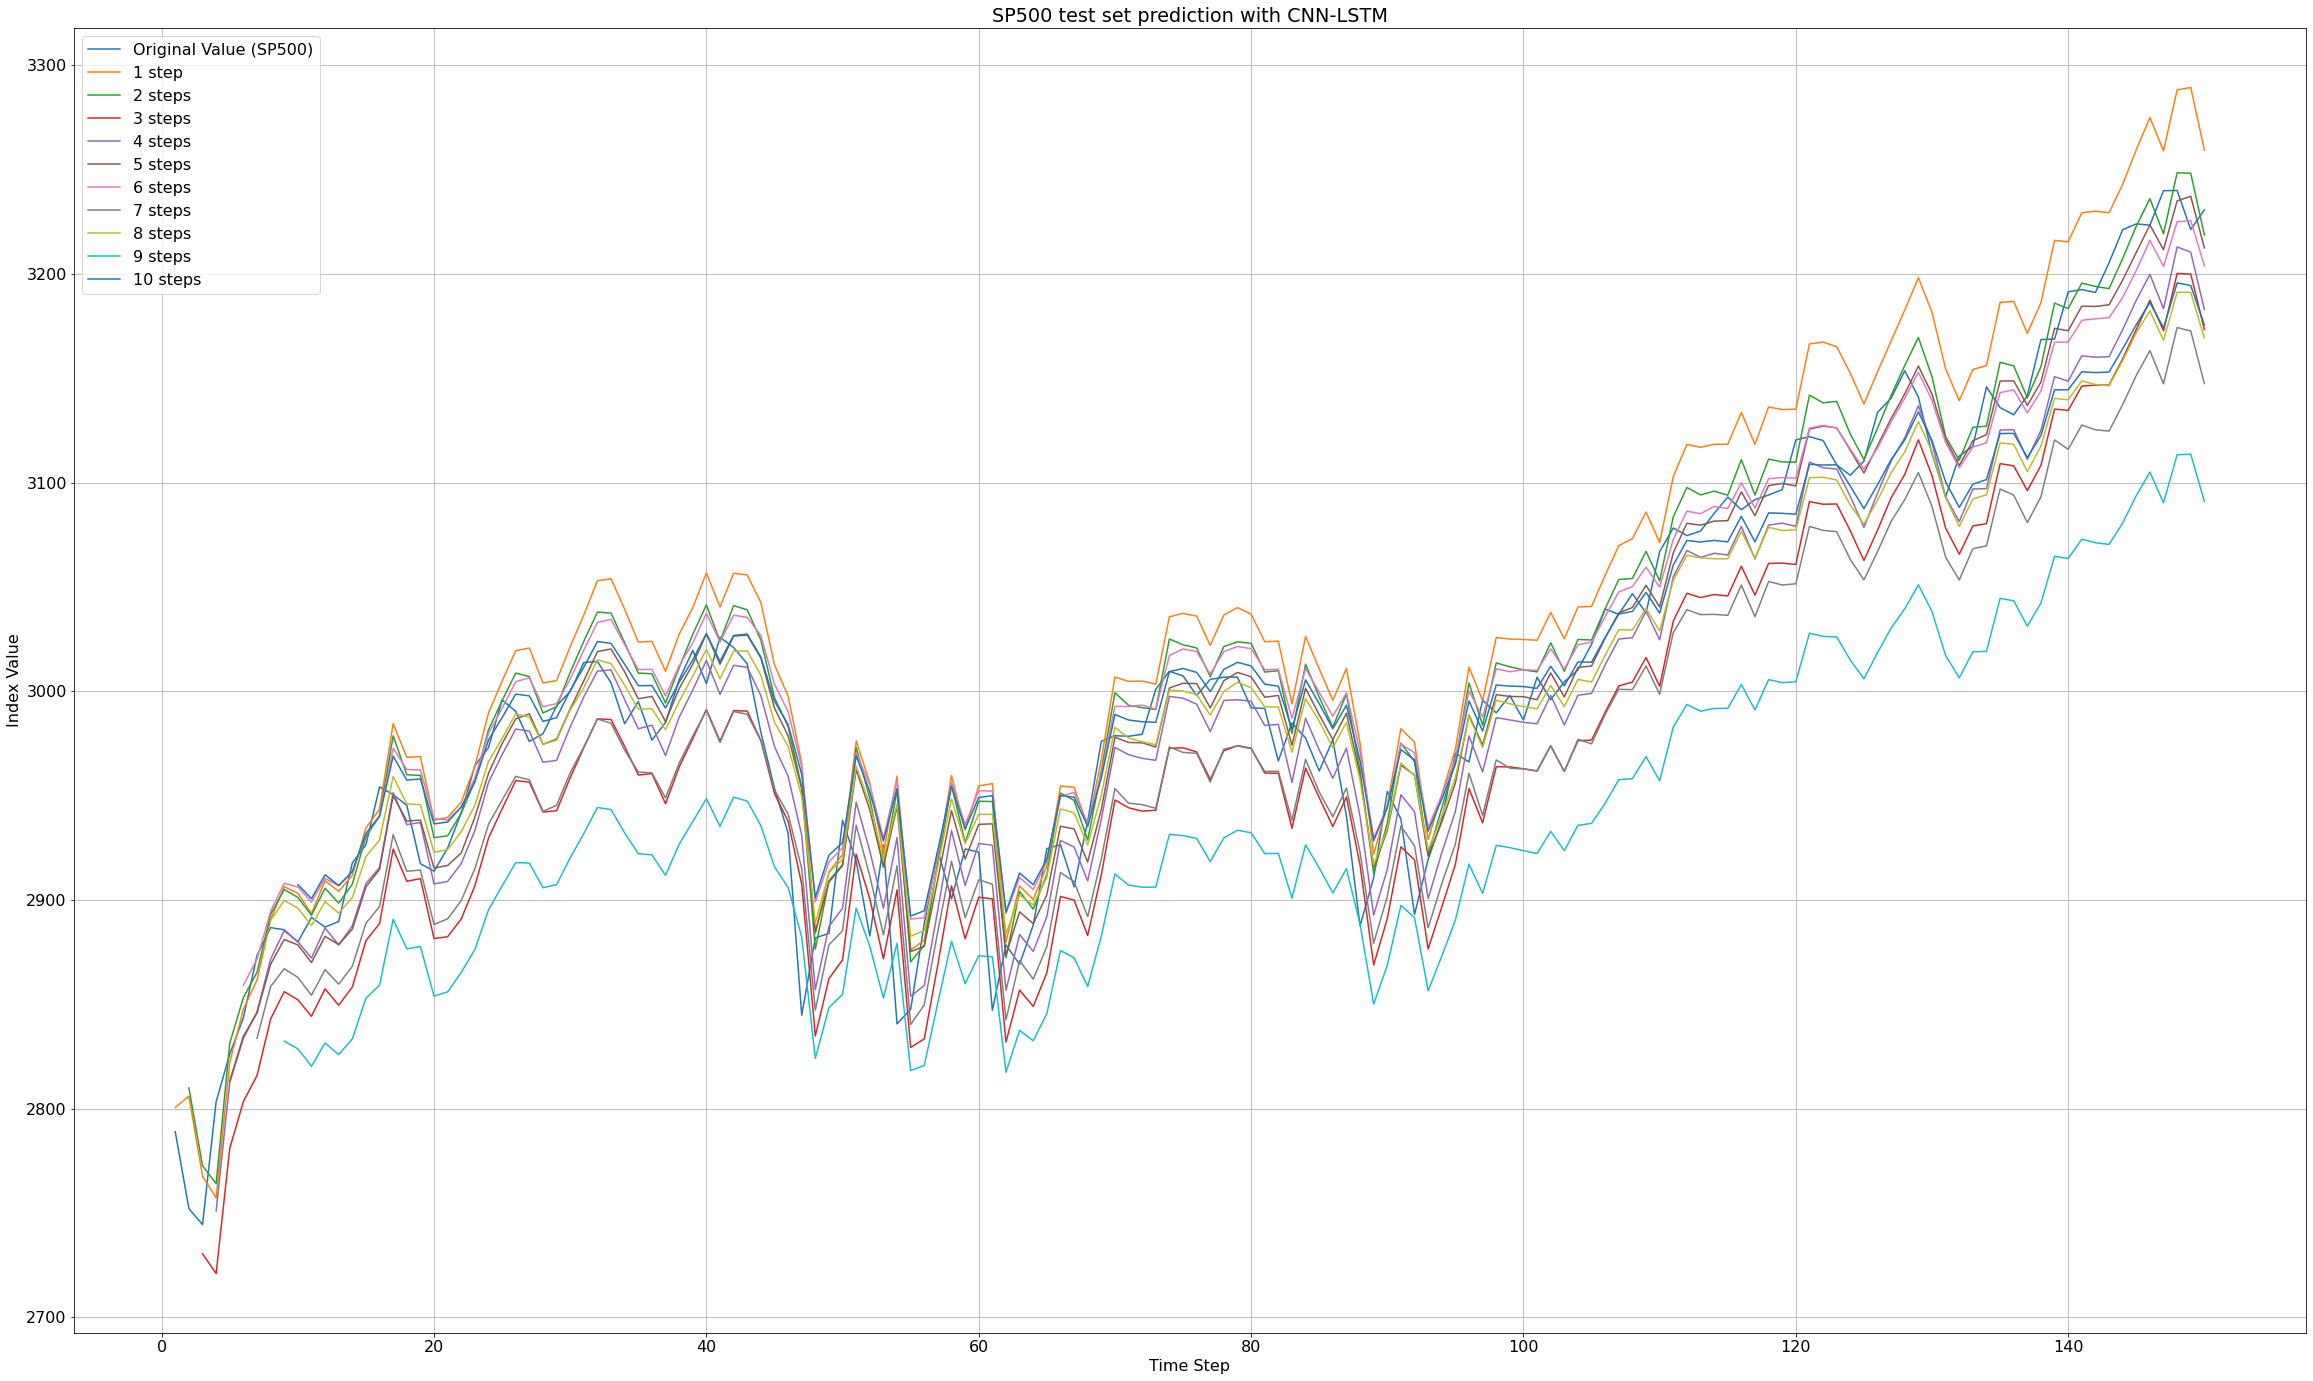

In [167]:
# Plot the forecast

plt.figure(figsize=(40, 24))
plot_series(np.arange( 1, len(time_test)+1 ), series_test)
plot_series(np.arange( 1, len(time_test)+1 ), series_test_hat_cnn_lstm_1)
plot_series(np.arange( 2, len(time_test)+1 ), series_test_hat_cnn_lstm_2)
plot_series(np.arange( 3, len(time_test)+1 ), series_test_hat_cnn_lstm_3)
plot_series(np.arange( 4, len(time_test)+1 ), series_test_hat_cnn_lstm_4)
plot_series(np.arange( 5, len(time_test)+1 ), series_test_hat_cnn_lstm_5)
plot_series(np.arange( 6, len(time_test)+1 ), series_test_hat_cnn_lstm_6)
plot_series(np.arange( 7, len(time_test)+1 ), series_test_hat_cnn_lstm_7)
plot_series(np.arange( 8, len(time_test)+1 ), series_test_hat_cnn_lstm_8)
plot_series(np.arange( 9, len(time_test)+1 ), series_test_hat_cnn_lstm_9)
plot_series(np.arange( 10, len(time_test)+1 ), series_test_hat_cnn_lstm_10)

plt.ylabel("Index Value")
plt.xlabel("Time Step")
plt.title("SP500 test set prediction with CNN-LSTM")
legend_drawn_flag = True
plt.legend(["Original Value (SP500)", "1 step","2 steps","3 steps","4 steps","5 steps","6 steps","7 steps","8 steps","9 steps","10 steps"], loc=0, frameon=legend_drawn_flag)
plt.savefig("/content/gdrive/MyDrive/Multistage/figures/cnn_lstm_forecasts_10steps_SP500.svg")

In [168]:
rmse_cnn_lstm_1, mae_cnn_lstm_1, mape_cnn_lstm_1= compute_metrics(series_test, series_test_hat_cnn_lstm_1)

print(f"rmse: {rmse_cnn_lstm_1:.2f}, mae: {mae_cnn_lstm_1:.2f} , mape: {mape_cnn_lstm_1:.2f} for 1 step forecast")

rmse: 38.84, mae: 31.82 , mape: 1.06 for 1 step forecast


In [169]:
rmse_cnn_lstm_2, mae_cnn_lstm_2, mape_cnn_lstm_2= compute_metrics(series_test[1:], series_test_hat_cnn_lstm_2)

print(f"rmse: {rmse_cnn_lstm_2:.2f}, mae: {mae_cnn_lstm_2:.2f} , mape: {mape_cnn_lstm_2:.2f} for 2 steps forecast")

rmse: 28.10, mae: 20.04 , mape: 0.68 for 2 steps forecast


In [170]:
rmse_cnn_lstm_3, mae_cnn_lstm_3, mape_cnn_lstm_3= compute_metrics(series_test[2:], series_test_hat_cnn_lstm_3)

print(f"rmse: {rmse_cnn_lstm_3:.2f}, mae: {mae_cnn_lstm_3:.2f} , mape: {mape_cnn_lstm_3:.2f} for 3 steps forecast")

rmse: 40.78, mae: 37.21 , mape: 1.24 for 3 steps forecast


In [171]:
rmse_cnn_lstm_4, mae_cnn_lstm_4, mape_cnn_lstm_4= compute_metrics(series_test[3:], series_test_hat_cnn_lstm_4)

print(f"rmse: {rmse_cnn_lstm_4:.2f}, mae: {mae_cnn_lstm_4:.2f} , mape: {mape_cnn_lstm_4:.2f} for 4 steps forecast")

rmse: 26.61, mae: 21.23 , mape: 0.71 for 4 steps forecast


In [172]:
rmse_cnn_lstm_5, mae_cnn_lstm_5, mape_cnn_lstm_5= compute_metrics(series_test[4:], series_test_hat_cnn_lstm_5)

print(f"rmse: {rmse_cnn_lstm_5:.2f}, mae: {mae_cnn_lstm_5:.2f} , mape: {mape_cnn_lstm_5:.2f} for 5 steps forecast")

rmse: 24.41, mae: 16.70 , mape: 0.56 for 5 steps forecast


In [173]:
rmse_cnn_lstm_6, mae_cnn_lstm_6, mape_cnn_lstm_6= compute_metrics(series_test[5:], series_test_hat_cnn_lstm_6)

print(f"rmse: {rmse_cnn_lstm_6:.2f}, mae: {mae_cnn_lstm_6:.2f} , mape: {mape_cnn_lstm_6:.2f} for 6 steps forecast")

rmse: 29.02, mae: 20.29 , mape: 0.68 for 6 steps forecast


In [174]:
rmse_cnn_lstm_7, mae_cnn_lstm_7, mape_cnn_lstm_7= compute_metrics(series_test[6:], series_test_hat_cnn_lstm_7)

print(f"rmse: {rmse_cnn_lstm_7:.2f}, mae: {mae_cnn_lstm_7:.2f} , mape: {mape_cnn_lstm_7:.2f} for 7 steps forecast")

rmse: 42.99, mae: 38.41 , mape: 1.27 for 7 steps forecast


In [175]:
rmse_cnn_lstm_8, mae_cnn_lstm_8, mape_cnn_lstm_8= compute_metrics(series_test[7:], series_test_hat_cnn_lstm_8)

print(f"rmse: {rmse_cnn_lstm_8:.2f}, mae: {mae_cnn_lstm_8:.2f} , mape: {mape_cnn_lstm_8:.2f} for 8 steps forecast")

rmse: 29.84, mae: 21.71 , mape: 0.72 for 8 steps forecast


In [176]:
rmse_cnn_lstm_9, mae_cnn_lstm_9, mape_cnn_lstm_9= compute_metrics(series_test[8:], series_test_hat_cnn_lstm_9)

print(f"rmse: {rmse_cnn_lstm_9:.2f}, mae: {mae_cnn_lstm_9:.2f} , mape: {mape_cnn_lstm_9:.2f} for 9 steps forecast")

rmse: 80.89, mae: 75.85 , mape: 2.50 for 9 steps forecast


In [177]:
rmse_cnn_lstm_10, mae_cnn_lstm_10, mape_cnn_lstm_10= compute_metrics(series_test[9:], series_test_hat_cnn_lstm_10)

print(f"rmse: {rmse_cnn_lstm_10:.2f}, mae: {mae_cnn_lstm_10:.2f} , mape: {mape_cnn_lstm_10:.2f} for 10 steps forecast")

rmse: 30.80, mae: 22.00 , mape: 0.73 for 10 steps forecast


In [178]:
# Save_weights model

cnn_lstm.save_weights("/content/gdrive/MyDrive/Multistage/models/cnn_lstm_SP500_MIMO.h5", overwrite=True, save_format=None, options=None)


In [179]:
# Save predicted values

np.savetxt("/content/gdrive/MyDrive/Multistage/files/cnn_lstm_predicted_test_SP500_1.csv", 
           series_test_hat_cnn_lstm_1.T, delimiter=",")
np.savetxt("/content/gdrive/MyDrive/Multistage/files/cnn_lstm_predicted_test_SP500_2.csv", 
           series_test_hat_cnn_lstm_2.T, delimiter=",")
np.savetxt("/content/gdrive/MyDrive/Multistage/files/cnn_lstm_predicted_test_SP500_3.csv", 
           series_test_hat_cnn_lstm_3.T, delimiter=",")
np.savetxt("/content/gdrive/MyDrive/Multistage/files/cnn_lstm_predicted_test_SP500_4.csv", 
           series_test_hat_cnn_lstm_4.T, delimiter=",")
np.savetxt("/content/gdrive/MyDrive/Multistage/files/cnn_lstm_predicted_test_SP500_5.csv", 
           series_test_hat_cnn_lstm_5.T, delimiter=",")
np.savetxt("/content/gdrive/MyDrive/Multistage/files/cnn_lstm_predicted_test_SP500_6.csv", 
           series_test_hat_cnn_lstm_6.T, delimiter=",")
np.savetxt("/content/gdrive/MyDrive/Multistage/files/cnn_lstm_predicted_test_SP500_7.csv", 
           series_test_hat_cnn_lstm_7.T, delimiter=",")
np.savetxt("/content/gdrive/MyDrive/Multistage/files/cnn_lstm_predicted_test_SP500_8.csv", 
           series_test_hat_cnn_lstm_8.T, delimiter=",")
np.savetxt("/content/gdrive/MyDrive/Multistage/files/cnn_lstm_predicted_test_SP500_9.csv", 
           series_test_hat_cnn_lstm_9.T, delimiter=",")
np.savetxt("/content/gdrive/MyDrive/Multistage/files/cnn_lstm_predicted_test_SP500_10.csv", 
           series_test_hat_cnn_lstm_10.T, delimiter=",")


np.savetxt("/content/gdrive/MyDrive/Multistage/files/cnn_lstm_predicted_whole_SP500.csv", 
           series_y_hat_cnn_lstm.T, delimiter=",")

# Plot together

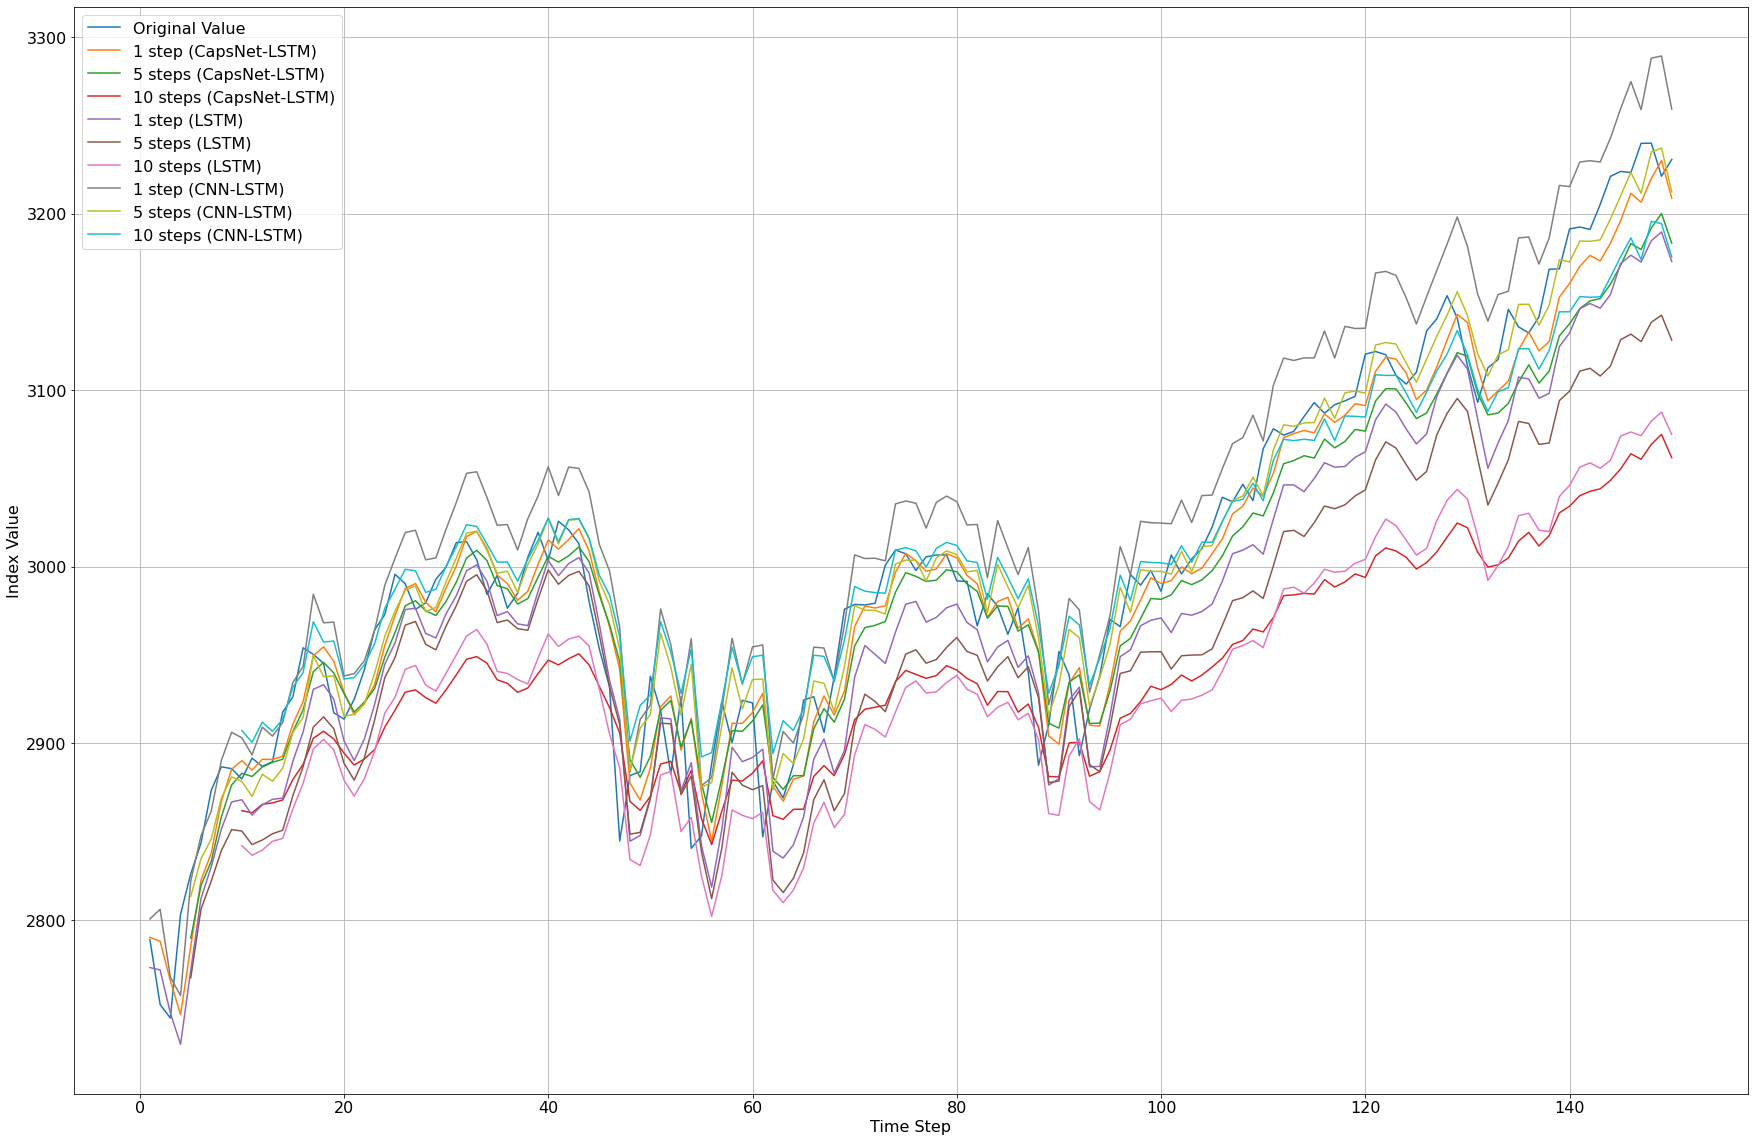

In [182]:
plt.figure(figsize=(30, 20))
plt.rcParams['font.size'] = '16'
plot_series(np.arange( 1, len(time_test)+1 ), series_test)

plot_series(np.arange( 1, len(time_test)+1 ), series_test_hat_capsnet_lstm_1)

plot_series(np.arange( 5, len(time_test)+1 ), series_test_hat_capsnet_lstm_5)

plot_series(np.arange( 10, len(time_test)+1 ), series_test_hat_capsnet_lstm_10)

plot_series(np.arange( 1, len(time_test)+1 ), series_test_hat_lstm_1)

plot_series(np.arange( 5, len(time_test)+1 ), series_test_hat_lstm_5)

plot_series(np.arange( 10, len(time_test)+1 ), series_test_hat_lstm_10)

plot_series(np.arange( 1, len(time_test)+1 ), series_test_hat_cnn_lstm_1)

plot_series(np.arange( 5, len(time_test)+1 ), series_test_hat_cnn_lstm_5)

plot_series(np.arange( 10, len(time_test)+1 ), series_test_hat_cnn_lstm_10)



plt.ylabel("Index Value")
plt.xlabel("Time Step")
legend_drawn_flag = True
plt.legend(["Original Value", "1 step (CapsNet-LSTM)","5 steps (CapsNet-LSTM)","10 steps (CapsNet-LSTM)", "1 step (LSTM)","5 steps (LSTM)","10 steps (LSTM)", "1 step (CNN-LSTM)","5 steps (CNN-LSTM)","10 steps (CNN-LSTM)"], loc=0, frameon=legend_drawn_flag)
plt.savefig("/content/gdrive/MyDrive/SP500/all_together_forecasts_SP500.svg")

RMSE:

In [183]:
RMSE_capsnet_lstm = [rmse_capsnet_lstm_1,rmse_capsnet_lstm_2,rmse_capsnet_lstm_3,rmse_capsnet_lstm_4,rmse_capsnet_lstm_5,rmse_capsnet_lstm_6,rmse_capsnet_lstm_7,rmse_capsnet_lstm_8,rmse_capsnet_lstm_9,rmse_capsnet_lstm_10]

In [184]:
RMSE_lstm = [rmse_lstm_1,rmse_lstm_2,rmse_lstm_3,rmse_lstm_4,rmse_lstm_5,rmse_lstm_6,rmse_lstm_7,rmse_lstm_8,rmse_lstm_9,rmse_lstm_10]

In [185]:
RMSE_cnn_lstm = [rmse_cnn_lstm_1,rmse_cnn_lstm_2,rmse_cnn_lstm_3,rmse_cnn_lstm_4,rmse_cnn_lstm_5,rmse_cnn_lstm_6,rmse_cnn_lstm_7,rmse_cnn_lstm_8,rmse_cnn_lstm_9,rmse_cnn_lstm_10]

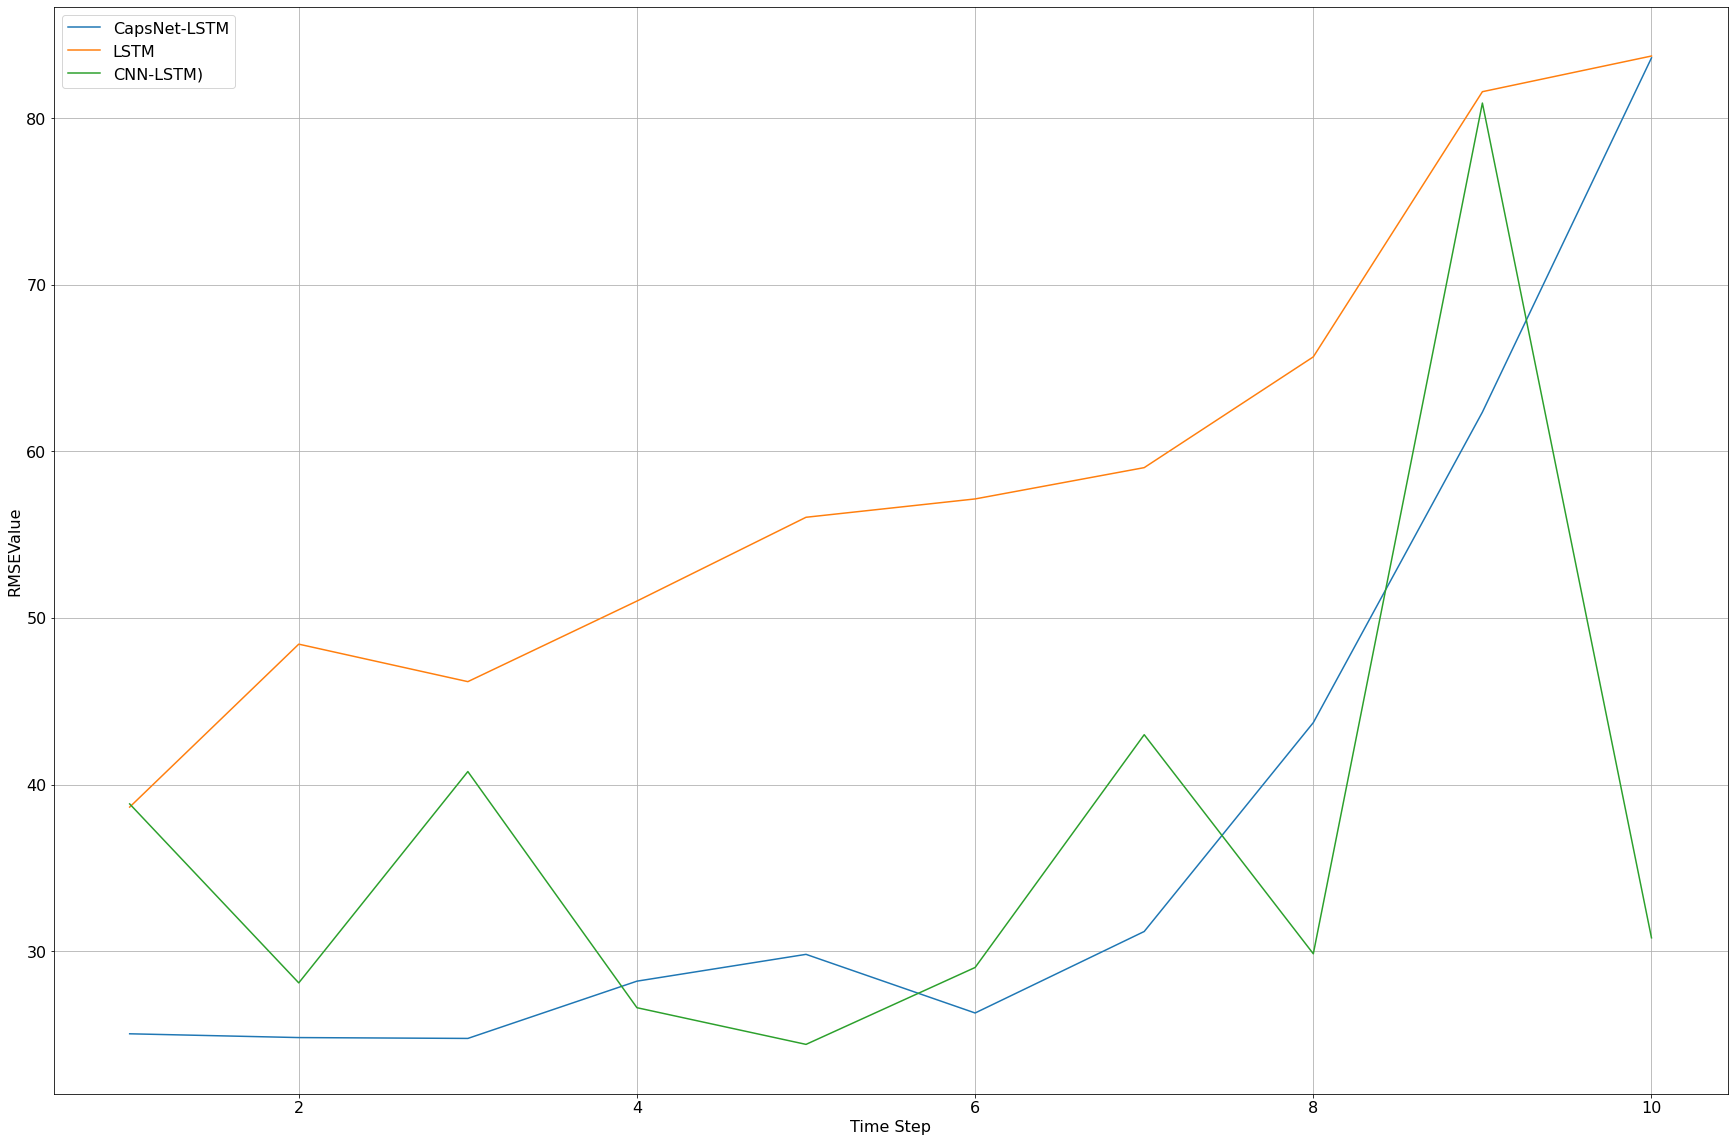

In [187]:
plt.figure(figsize=(30, 20))
plt.rcParams['font.size'] = '16'
plot_series(np.arange( 1, 11 ), RMSE_capsnet_lstm)

plot_series(np.arange( 1, 11 ), RMSE_lstm)

plot_series(np.arange( 1, 11 ), RMSE_cnn_lstm)

plt.ylabel("RMSEValue")
plt.xlabel("Time Step")
legend_drawn_flag = True
plt.legend(["CapsNet-LSTM","LSTM","CNN-LSTM)"], loc=0, frameon=legend_drawn_flag)
plt.savefig("/content/gdrive/MyDrive/SP500/RMSE_10_steps_SP500.svg")

MAE:

MAPE: